In [1]:
!where python
!py -m pip show torch

c:\Users\hi\AppData\Local\Programs\Python\Python310\python.exe
C:\Users\hi\AppData\Local\Microsoft\WindowsApps\python.exe
Name: torch
Version: 2.5.1
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3-Clause
Location: c:\users\hi\appdata\local\programs\python\python310\lib\site-packages
Requires: filelock, fsspec, jinja2, networkx, sympy, typing-extensions
Required-by: grad-cam, timm, torchaudio, torchvision


In [2]:
# CELL 1: 📦 Import Library

# --- Standard library imports ---
import os                      # Akses file & environment
import sys                     # Akses argumen CLI & sistem
import io                      # Operasi stream I/O
import time                    # Fungsi waktu (sleep, time)
import random                  # Operasi acak (randint, shuffle)
import json                    # Baca/tulis file JSON
import warnings                # Kontrol peringatan
from datetime import datetime  # Tanggal & waktu sekarang
from collections import Counter  # Hitung frekuensi elemen

# --- IPython and Jupyter utilities ---
import ipywidgets as widgets                               # Widget interaktif di Jupyter
from IPython.display import display, Image as IPImage, clear_output  # Tampilkan gambar/output

# --- Third-party libraries ---
import numpy as np                                         # Operasi numerik (array, matrix)
import pandas as pd                                        # Manipulasi data (DataFrame)
import cv2                                                 # Pemrosesan citra (OpenCV)
import matplotlib.pyplot as plt                            # Visualisasi grafik
from matplotlib.patches import Patch                       # Elemen custom untuk legenda
from PIL import Image as PILImage                          # Buka dan manipulasi gambar (PIL)
from tqdm import tqdm                                      # Progress bar loop
import torch                                               # Framework utama deep learning
import torch.nn as nn                                      # Neural network module PyTorch
import torch.optim as optim                                # Optimizer (SGD, Adam, dll)
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler  # Dataset & sampling
from torch.cuda import amp                                 # Mixed precision training (fp16)
import torchvision.transforms as transforms                # Transformasi gambar (resize, normalize, dll)
import timm                                                # Pretrained model dari TIMM
import albumentations as A                                 # Augmentasi gambar
from albumentations.pytorch import ToTensorV2              # Konversi ke tensor PyTorch
from sklearn.model_selection import train_test_split, StratifiedKFold  # Split & K-Fold Stratifikasi
from sklearn.metrics import classification_report, confusion_matrix    # Evaluasi model
from sklearn.utils.class_weight import compute_class_weight           # Hitung class weight

# --- Miscellaneous ---
import glob                         # Ambil file sesuai pola (wild  card)

# --- Ignore warnings ---
warnings.filterwarnings('ignore')  # Nonaktifkan peringatan runtime

Matplotlib is building the font cache; this may take a moment.


In [3]:
# GPU

import torch
import numpy as np
#Cell 2: Set Device cuda🔌💻 (Menghubungkan ke perangkat CUDA - GPU)

#Konfigurasi Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# GPU optimization settings
torch.backends.cudnn.benchmark = True
torch.set_float32_matmul_precision('medium')  # For PyTorch 2.0+
if device.type == 'cuda':
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory/1024**3:.2f} GB")

Using device: cpu


In [4]:
# Set seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
if device.type == 'cuda':
    torch.cuda.manual_seed_all(SEED)

In [5]:
# CELL 3: Definisi Konfigurasi Training (CONFIG) ⚙️📋 ---
CONFIG = {
    # --- Konfigurasi Model ---
    'model_name': 'swin_tiny_patch4_window7_224.ms_in22k', # Nama model dari timm
    'TARGET_SIZE': 224,                        # Ukuran target gambar input untuk model dan augmentasi
    'num_classes': 3,                          # Jumlah kelas output (Healthy, BG, WSSV)

    # --- Konfigurasi Training ---
    'batch_size': 8,                           # Batch size aktual per GPU/device
    'val_batch_size': 16,                      # Batch size untuk validasi (bisa berbeda)
    'accumulation_steps': 4,                   # Langkah akumulasi gradien untuk effective batch size
    'lr': 3e-5,                                # Learning rate awal
    'weight_decay': 0.04,                      # Weight decay untuk optimizer
    'dropout_head': 0.3,                       # Dropout rate untuk head classifier model
    'drop_path_rate': 0.2,                     # Stochastic depth rate untuk model (jika didukung)
    'optimizer_name': 'AdamW',                 # Nama optimizer (misalnya, 'AdamW', 'SGD')
    'scheduler_name': 'CosineAnnealingLR',     # Nama scheduler ('cosine', 'ReduceLROnPlateau', atau None)
    'scheduler_warmup_epochs': 3,              # Jumlah epoch untuk warmup scheduler (jika relevan)
    'eta_min_cosine': 1e-7,                    # Learning rate minimum untuk CosineAnnealingLR
    'scheduler_factor': 0.2,                   # Faktor pengurangan LR untuk ReduceLROnPlateau
    'scheduler_patience_plateau': 3,           # Kesabaran untuk ReduceLROnPlateau
    'max_epochs_per_fold': 15,                 # Jumlah maksimum epoch per fold
    'early_stopping_patience': 5,              # Kesabaran untuk early stopping
    'early_stopping_delta': 0.001,             # Perubahan minimum yang dianggap sebagai perbaikan untuk early stopping

    # --- Konfigurasi K-Fold & Data Loader ---
    'num_folds': 5,                            # Jumlah fold untuk K-Fold Cross-Validation
    'num_workers': 0,                          # Jumlah worker
    'SEED': SEED,                              # Seed untuk reproduktibilitas (menggunakan SEED global)

    # --- Konfigurasi Data Asli ---
    'base_original_data_dir': r"D:\Skripsi\Shrimp_Classifier\Shrimp_Classifier\data\raw", # Path dasar ke data asli
    'dataset_sources': ["Dataset_A", "Dataset_B"], # Daftar subfolder sumber dataset
    'class_map_raw': {"1. Healthy": "Healthy", "2. BG": "BG", "3. WSSV": "WSSV"}, # Pemetaan nama folder asli ke nama kelas standar
    'valid_class_names': ["Healthy", "BG", "WSSV"], # Daftar nama kelas standar (menentukan urutan juga)
    'hold_out_test_ratio': 0.15,               # Rasio data untuk hold-out test set

    # --- Parameter Augmentasi Training ---
    'IMAGENET_MEAN': [0.485, 0.456, 0.406],     # Rata-rata ImageNet untuk normalisasi
    'IMAGENET_STD': [0.229, 0.224, 0.225],      # Standar deviasi ImageNet untuk normalisasi
    'aug_train_rr_crop_scale': (0.6, 1.0),      # RandomResizedCrop: skala area crop
    'aug_train_rr_crop_ratio': (0.75, 1.33),   # RandomResizedCrop: rasio aspek crop
    'aug_train_hflip_p': 0.5,                  # HorizontalFlip: probabilitas
    'aug_train_vflip_p': 0.3,                  # VerticalFlip: probabilitas
    'aug_train_ssr_shift': 0.06,               # ShiftScaleRotate: batas pergeseran
    'aug_train_ssr_scale': 0.1,                # ShiftScaleRotate: batas penskalaan
    'aug_train_ssr_rotate': 35,                # ShiftScaleRotate: batas rotasi (derajat)
    'aug_train_ssr_p': 0.7,                    # ShiftScaleRotate: probabilitas
    'aug_train_cj_brightness': 0.25,           # ColorJitter: kecerahan
    'aug_train_cj_contrast': 0.25,             # ColorJitter: kontras
    'aug_train_cj_saturation': 0.25,           # ColorJitter: saturasi
    'aug_train_cj_hue': 0.05,                  # ColorJitter: hue
    'aug_train_cj_p': 0.75,                    # ColorJitter: probabilitas
    'aug_train_hsv_hue': 15,                   # HueSaturationValue: pergeseran hue
    'aug_train_hsv_sat': 25,                   # HueSaturationValue: pergeseran saturasi
    'aug_train_hsv_val': 15,                   # HueSaturationValue: pergeseran nilai (brightness)
    'aug_train_hsv_p': 0.5,                    # HueSaturationValue: probabilitas
    'aug_train_clahe_clip': (1, 4),            # CLAHE: batas kontras
    'aug_train_clahe_tile': (8, 8),            # CLAHE: ukuran grid tile
    'aug_train_clahe_p': 0.5,                  # CLAHE: probabilitas
    'aug_train_gamma_limit': (80, 120),        # RandomGamma: batas gamma
    'aug_train_gamma_p': 0.3,                  # RandomGamma: probabilitas
    'aug_train_dropout_max_holes': 10,         # CoarseDropout: maks lubang
    'aug_train_dropout_max_h_factor': 0.1,     # CoarseDropout: tinggi maks lubang (faktor dari TARGET_SIZE)
    'aug_train_dropout_max_w_factor': 0.1,     # CoarseDropout: lebar maks lubang (faktor dari TARGET_SIZE)
    'aug_train_dropout_min_holes': 1,          # CoarseDropout: min lubang
    'aug_train_dropout_min_h_factor': 0.05,    # CoarseDropout: tinggi min lubang (faktor dari TARGET_SIZE)
    'aug_train_dropout_min_w_factor': 0.05,    # CoarseDropout: lebar min lubang (faktor dari TARGET_SIZE)
    'aug_train_dropout_p': 0.5,                # CoarseDropout: probabilitas

    # --- Parameter Augmentasi Validasi/Test ---
    'aug_val_resize_size': 256,                # Resize: ukuran awal gambar sebelum CenterCrop
                                               # CenterCrop akan menggunakan CONFIG['TARGET_SIZE']

    # --- Konfigurasi Lain & Path Penyimpanan ---
    'use_class_weights': True,                 # Opsi untuk menggunakan class weights saat training atau tidak
    'output_base_dir': 'outputs_training_final', # Direktori dasar untuk semua output training ini (nama contoh)
    # Path lain akan dibangun dari output_base_dir di bawah
}

# Membangun path output secara dinamis dari output_base_dir
# Ini membuat lebih mudah jika ingin mengubah lokasi semua output sekaligus
if 'output_base_dir' in CONFIG:
    CONFIG['model_save_dir'] = os.path.join(CONFIG['output_base_dir'], 'models')
    CONFIG['fold_results_save_path'] = os.path.join(CONFIG['output_base_dir'], 'fold_results_summary.json')
    CONFIG['oof_data_npz_path'] = os.path.join(CONFIG['output_base_dir'], 'overall_oof_data.npz')
    CONFIG['output_splits_dir'] = os.path.join(CONFIG['output_base_dir'], 'data_splits') # Untuk CSV split data dari Cell 3
else:
    # Fallback jika output_base_dir tidak ada (meskipun seharusnya ada)
    CONFIG['model_save_dir'] = 'models_output'
    CONFIG['fold_results_save_path'] = 'fold_results_summary.json'
    CONFIG['oof_data_npz_path'] = 'overall_oof_data.npz'
    CONFIG['output_splits_dir'] = 'output_splits'


print("Konfigurasi training (CONFIG) telah didefinisikan.")
print(f"  Model: {CONFIG['model_name']}")
print(f"  Target Size: {CONFIG['TARGET_SIZE']}")
print(f"  Num Workers: {CONFIG['num_workers']}")
print(f"  Effective batch size akan menjadi: {CONFIG['batch_size'] * CONFIG['accumulation_steps']}")
print(f"  Seed yang digunakan: {CONFIG['SEED']}")
print(f"  Model akan disimpan di: {CONFIG.get('model_save_dir', 'N/A')}") # Gunakan .get() untuk keamanan jika path tidak terdefinisi
print(f"  Hasil fold akan disimpan ke: {CONFIG.get('fold_results_save_path', 'N/A')}")
print(f"  Parameter Augmentasi Training (contoh HFlip prob): {CONFIG.get('aug_train_hflip_p', 'N/A')}")

Konfigurasi training (CONFIG) telah didefinisikan.
  Model: swin_tiny_patch4_window7_224.ms_in22k
  Target Size: 224
  Num Workers: 0
  Effective batch size akan menjadi: 32
  Seed yang digunakan: 42
  Model akan disimpan di: outputs_training_final\models
  Hasil fold akan disimpan ke: outputs_training_final\fold_results_summary.json
  Parameter Augmentasi Training (contoh HFlip prob): 0.5


In [6]:
# Cell 4: Fungsi Pengumpulan dan Analisis Data Awal

print("\n" + "="*30)
print("Cell 4: Pengumpulan dan Analisis Data Awal")
print("="*30)

# Pastikan CONFIG Sudah Ada
if 'CONFIG' not in globals():
    print("ERROR: Variabel CONFIG belum terdefinisi. Jalankan cell definisi CONFIG terlebih dahulu!")
    # Hentikan eksekusi atau berikan default jika CONFIG sangat krusial
    raise NameError("CONFIG is not defined. Please define it in a preceding cell.")

# Fungsi Pengumpulan Data (menggunakan CONFIG)
def collect_original_image_data(config_dict):
    """Mengumpulkan path gambar, label, dan sumber dataset dari data asli menggunakan CONFIG."""
    data = []
    base_dir = config_dict.get('base_original_data_dir')
    dataset_sources_list = config_dict.get('dataset_sources', [])
    class_map_raw_from_config = config_dict.get('class_map_raw', {})
    valid_class_names_from_config = config_dict.get('valid_class_names', [])

    if not base_dir:
        print("ERROR: 'base_original_data_dir' tidak ditemukan di CONFIG.")
        return pd.DataFrame(data)

    print(f"DEBUG [collect_original_image_data]: Base directory: {base_dir}")
    print(f"DEBUG [collect_original_image_data]: Dataset sources: {dataset_sources_list}")
    print(f"DEBUG [collect_original_image_data]: Class map raw: {class_map_raw_from_config}")
    print(f"DEBUG [collect_original_image_data]: Valid class names: {valid_class_names_from_config}")

    for dataset_source in dataset_sources_list:
        source_path = os.path.join(base_dir, dataset_source)
        if not os.path.isdir(source_path):
            print(f"Warning: Direktori sumber tidak ditemukan - {source_path}")
            continue
            
        for class_folder_raw in os.listdir(source_path):
            class_name = class_map_raw_from_config.get(class_folder_raw, class_folder_raw)
            class_path = os.path.join(source_path, class_folder_raw)
            if not os.path.isdir(class_path):
                continue
            
            if class_name not in valid_class_names_from_config:
                if class_folder_raw in class_map_raw_from_config or class_name not in valid_class_names_from_config :
                       print(f"Warning: Nama folder kelas '{class_folder_raw}' (menjadi '{class_name}') tidak ada dalam 'valid_class_names' di CONFIG. Skipping di {source_path}")
                continue

            for image_name in os.listdir(class_path):
                if image_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    image_path = os.path.join(class_path, image_name)
                    data.append({
                        "image_path": image_path,
                        "label": class_name,
                        "source": dataset_source
                    })
    return pd.DataFrame(data)

# --- Fungsi Analisis Data ---
df_all_original_global = pd.DataFrame() # Inisialisasi di luar fungsi

def analyze_data_distribution(df, title_prefix="", known_labels_for_crosstab=None):
    """Menganalisis dan mencetak distribusi data."""
    if df.empty:
        print(f"Tidak ada data untuk dianalisis untuk: {title_prefix}")
        return
    print(f"\n--- Analisis Distribusi Data: {title_prefix} ---")
    print(f"Total gambar: {len(df)}")
    
    print("\nDistribusi Kelas:")
    print(df['label'].value_counts(normalize=True).mul(100).round(2).astype(str) + '%')
    print(df['label'].value_counts().to_string())
    
    print("\nDistribusi Sumber Dataset:")
    if 'source' in df.columns:
        print(df['source'].value_counts(normalize=True).mul(100).round(2).astype(str) + '%')
        print(df['source'].value_counts().to_string())
    else:
        print("Kolom 'source' tidak ditemukan dalam DataFrame.")
    
    print("\nDistribusi Kelas per Sumber Dataset:")
    if 'source' in df.columns and 'label' in df.columns:
        try:
            if known_labels_for_crosstab is None:
                known_labels_for_crosstab = sorted(df['label'].unique())

            if known_labels_for_crosstab:
                crosstab_df = pd.crosstab(df['source'], df['label'])
                crosstab_df = crosstab_df.reindex(columns=known_labels_for_crosstab, fill_value=0)
                print(crosstab_df.to_string())
            else:
                print("Tidak ada label yang diketahui untuk membuat crosstab.")
        except Exception as e:
            print(f"Error saat membuat crosstab: {e}")
    print("--- Akhir Analisis ---")

# --- Proses Utama Cell ---

# 1. Mengumpulkan data menggunakan CONFIG
print("Memulai pengumpulan data asli...")
df_all_original_global = collect_original_image_data(CONFIG)

if not df_all_original_global.empty:
    # Menggunakan valid_class_names dari CONFIG untuk analisis distribusi yang konsisten
    analyze_data_distribution(df_all_original_global,
                              "Keseluruhan Data Asli Gabungan (A & B)",
                              known_labels_for_crosstab=CONFIG.get('valid_class_names'))

    # 2. Pemetaan label string ke integer untuk model
    unique_labels_sorted = CONFIG.get('valid_class_names', sorted(df_all_original_global['label'].unique()))
    
    label_to_int = {label: i for i, label in enumerate(unique_labels_sorted)}
    int_to_label = {i: label for label, i in label_to_int.items()}
    df_all_original_global['label_int'] = df_all_original_global['label'].map(label_to_int)
    
    print("\nLabel Mapping (Kelas String ke Integer):")
    print(f"  {label_to_int}")
    print("Pemetaan Integer ke Kelas String:")
    print(f"  {int_to_label}")

else:
    print("DataFrame df_all_original_global kosong setelah proses pengumpulan data.")
    print("Pastikan path 'base_original_data_dir' dan struktur folder di CONFIG sudah benar dan ada gambar di dalamnya.")
    X = np.array([])
    y = np.array([])
    # df_development dan df_hold_out_test akan otomatis kosong jika df_all_original_global kosong


Cell 4: Pengumpulan dan Analisis Data Awal
Memulai pengumpulan data asli...
DEBUG [collect_original_image_data]: Base directory: D:\Skripsi\Shrimp_Classifier\Shrimp_Classifier\data\raw
DEBUG [collect_original_image_data]: Dataset sources: ['Dataset_A', 'Dataset_B']
DEBUG [collect_original_image_data]: Class map raw: {'1. Healthy': 'Healthy', '2. BG': 'BG', '3. WSSV': 'WSSV'}
DEBUG [collect_original_image_data]: Valid class names: ['Healthy', 'BG', 'WSSV']

--- Analisis Distribusi Data: Keseluruhan Data Asli Gabungan (A & B) ---
Total gambar: 1599

Distribusi Kelas:
Healthy    49.66%
WSSV        37.9%
BG         12.45%
Name: label, dtype: object
Healthy    794
WSSV       606
BG         199

Distribusi Sumber Dataset:
Dataset_B    59.47%
Dataset_A    40.53%
Name: source, dtype: object
Dataset_B    951
Dataset_A    648

Distribusi Kelas per Sumber Dataset:
label      Healthy   BG  WSSV
source                       
Dataset_A      371  160   117
Dataset_B      423   39   489
--- Akhir Ana

In [ ]:
# 3. Pemisahan Hold-Out Test Set
hold_out_test_ratio = CONFIG.get('hold_out_test_ratio', 0.15)
current_seed_for_split = CONFIG.get('SEED')

if current_seed_for_split is None:
    raise ValueError("SEED tidak ditemukan di CONFIG, diperlukan untuk pemisahan data.")

df_development, df_hold_out_test = train_test_split(
    df_all_original_global,
    test_size=hold_out_test_ratio,
    stratify=df_all_original_global['label_int'],
    random_state=current_seed_for_split
)

In [ ]:
print(f"\nData telah dibagi menjadi Development Set dan Hold-Out Test Set.")
analyze_data_distribution(df_development,
                          f"Development Set (untuk K-Fold, {100*(1-hold_out_test_ratio):.0f}%)",
                          known_labels_for_crosstab=CONFIG.get('valid_class_names'))
analyze_data_distribution(df_hold_out_test,
                          f"Hold-Out Test Set ({100*hold_out_test_ratio:.0f}%)",
                          known_labels_for_crosstab=CONFIG.get('valid_class_names'))

# 4. Simpan hold-out test set ke CSV dengan TIMESTAMP
output_dir_splits = CONFIG.get('output_splits_dir', "output_splits")
os.makedirs(output_dir_splits, exist_ok=True)

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
hold_out_filename = f"hold_out_test_set_asli_{timestamp}.csv"
hold_out_test_set_path = os.path.join(output_dir_splits, hold_out_filename)

try:
    df_hold_out_test.to_csv(hold_out_test_set_path, index=False)
    print(f"\nHold-out test set disimpan ke: {hold_out_test_set_path}")
except Exception as e_csv_save:
    print(f"ERROR saat menyimpan hold-out test set: {e_csv_save}")


Data telah dibagi menjadi Development Set dan Hold-Out Test Set.

--- Analisis Distribusi Data: Development Set (untuk K-Fold, 85%) ---
Total gambar: 1359

Distribusi Kelas:
Healthy    49.67%
WSSV        37.9%
BG         12.44%
Name: label, dtype: object
Healthy    675
WSSV       515
BG         169

Distribusi Sumber Dataset:
Dataset_B    59.75%
Dataset_A    40.25%
Name: source, dtype: object
Dataset_B    812
Dataset_A    547

Distribusi Kelas per Sumber Dataset:
label      Healthy   BG  WSSV
source                       
Dataset_A      312  134   101
Dataset_B      363   35   414
--- Akhir Analisis ---

--- Analisis Distribusi Data: Hold-Out Test Set (15%) ---
Total gambar: 240

Distribusi Kelas:
Healthy    49.58%
WSSV       37.92%
BG          12.5%
Name: label, dtype: object
Healthy    119
WSSV        91
BG          30

Distribusi Sumber Dataset:
Dataset_B    57.92%
Dataset_A    42.08%
Name: source, dtype: object
Dataset_B    139
Dataset_A    101

Distribusi Kelas per Sumber Dataset

In [10]:
# 5. Menyiapkan X dan y untuk K-Fold (dari df_development)
X = df_development['image_path'].values
y = df_development['label_int'].values
    
print(f"\nVariabel X (total {len(X)} path gambar dari Development Set) dan y (total {len(y)} label dari Development Set) telah disiapkan untuk K-Fold.")


Variabel X (total 1359 path gambar dari Development Set) dan y (total 1359 label dari Development Set) telah disiapkan untuk K-Fold.



Memulai visualisasi data dari df_all_original_global...


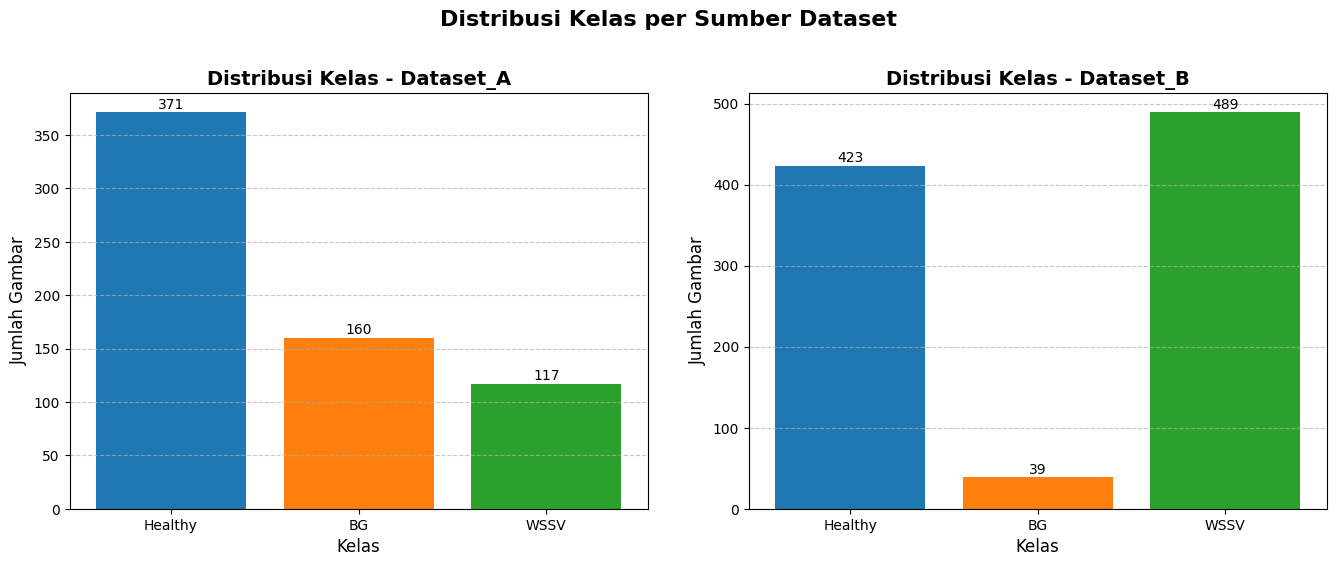


Visualisasi selesai (jika data tersedia).


In [11]:
# 4.1 Visualisasi Distribusi Kelas
if not df_all_original_global.empty : # Hanya visualisasi jika ada data
    print("\nMemulai visualisasi data dari df_all_original_global...")
    
    # a. Persiapan Data untuk Bar/Pie Charts
    df_for_visualization = df_all_original_global # df_all_original_global sudah terdefinisi
    dataset_class_counts = {}
    if 'source' in df_for_visualization.columns:
        for source_name, group_df in df_for_visualization.groupby('source'):
            dataset_class_counts[source_name] = Counter(group_df['label'])
    else:
        print("Warning: Kolom 'source' tidak ada di df_for_visualization, visualisasi per sumber dilewati.")

    # Definisi Urutan dan Warna yang Diinginkan 
    TARGET_CLASS_ORDER = CONFIG.get('valid_class_names', ["Healthy", "BG", "WSSV"]) # Ambil dari CONFIG
    # Warna bisa juga dari CONFIG jika ingin lebih fleksibel
    TARGET_COLORS = CONFIG.get('target_colors_viz', ['#1f77b4', '#ff7f0e', '#2ca02c']) 

    if not dataset_class_counts:
        print("Tidak ada data dalam 'dataset_class_counts' untuk divisualisasikan (bar/pie).")
    else:
        # b. Visualisasi Distribusi Kelas (Bar Chart)
        sorted_dataset_sources = sorted(dataset_class_counts.keys())
        
        if not sorted_dataset_sources:
            print("Tidak ada sumber dataset yang ditemukan untuk bar chart.")
        else:
            # Impor matplotlib.pyplot jika belum
            try:
                import matplotlib.pyplot as plt
                from matplotlib.patches import Patch
            except ImportError:
                print("Matplotlib tidak terinstal. Lewati visualisasi.")
                # Atur can_visualize menjadi False atau handle error
            else:
                fig_bar, ax_bar_array = plt.subplots(1, len(sorted_dataset_sources), 
                                                     figsize=(7 * len(sorted_dataset_sources), 6), 
                                                     squeeze=False)
                ax_bar_array = ax_bar_array.flatten()

                for i, source_name in enumerate(sorted_dataset_sources):
                    current_axe_bar = ax_bar_array[i]
                    source_counts_dict = dataset_class_counts[source_name]
                    
                    plot_values_bar = [source_counts_dict.get(label, 0) for label in TARGET_CLASS_ORDER]
                    
                    bars = current_axe_bar.bar(TARGET_CLASS_ORDER, plot_values_bar, color=TARGET_COLORS[:len(TARGET_CLASS_ORDER)]) # Pastikan warna cukup
                    current_axe_bar.set_title(f'Distribusi Kelas - {source_name}', fontsize=14, fontweight='bold')
                    current_axe_bar.set_xlabel('Kelas', fontsize=12)
                    current_axe_bar.set_ylabel('Jumlah Gambar', fontsize=12)
                    current_axe_bar.grid(axis='y', linestyle='--', alpha=0.7)
                    current_axe_bar.tick_params(axis='x', rotation=0)

                    for bar_item in bars:
                        height = bar_item.get_height()
                        offset = max(1, 0.001 * sum(plot_values_bar)) if sum(plot_values_bar) > 0 else 1 
                        current_axe_bar.text(bar_item.get_x() + bar_item.get_width()/2., height + offset,
                                             f'{int(height)}',
                                             ha='center', va='bottom', fontsize=10)
                
                plt.tight_layout(pad=3.0, rect=[0, 0, 1, 0.95]) 
                fig_bar.suptitle("Distribusi Kelas per Sumber Dataset", fontsize=16, fontweight='bold')
                plt.show()
    print("\nVisualisasi selesai (jika data tersedia).")
else:
    print("Visualisasi dilewati karena tidak ada data yang terkumpul.")

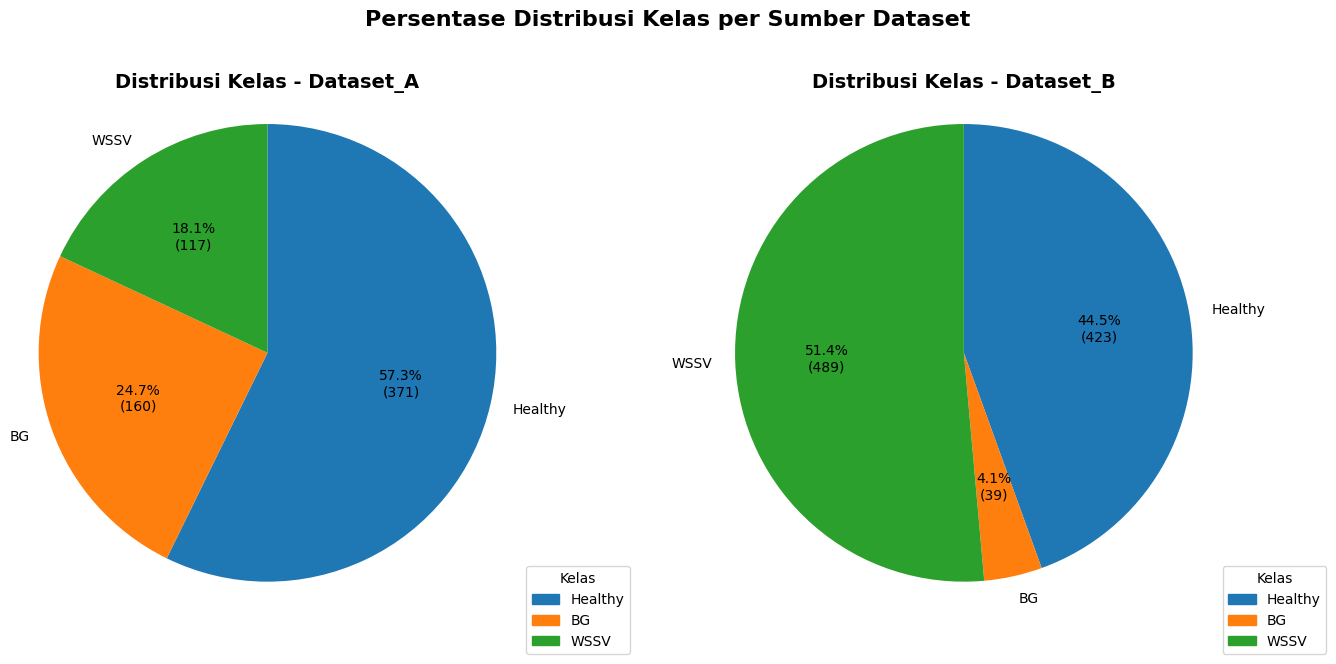

In [18]:
# c. Visualisasi Distribusi Kelas (Pie Chart)

# Pastikan CONFIG, sorted_dataset_sources, dan dataset_class_counts sudah ada
if 'CONFIG' not in globals():
    print("ERROR: Variabel CONFIG belum terdefinisi. Lewati visualisasi pie chart.")
elif 'sorted_dataset_sources' not in globals() or 'dataset_class_counts' not in globals():
    print("ERROR: Variabel sorted_dataset_sources atau dataset_class_counts belum terdefinisi. Lewati visualisasi pie chart.")
elif not sorted_dataset_sources: # Cek jika sorted_dataset_sources kosong
    print("Tidak ada sumber dataset yang ditemukan untuk pie chart.")
else:
    # Ambil TARGET_CLASS_ORDER dan TARGET_COLORS dari CONFIG
    # Menyediakan nilai default jika kunci tidak ada di CONFIG
    TARGET_CLASS_ORDER = CONFIG.get('valid_class_names', ["Healthy", "BG", "WSSV"]) # Gunakan valid_class_names sebagai urutan
    TARGET_COLORS = CONFIG.get('target_colors_viz', ['#1f77b4', '#ff7f0e', '#2ca02c']) # Warna default

    # Pastikan jumlah warna sesuai dengan jumlah kelas di TARGET_CLASS_ORDER
    if len(TARGET_COLORS) < len(TARGET_CLASS_ORDER):
        print(f"Warning: Jumlah warna ({len(TARGET_COLORS)}) di CONFIG['target_colors_viz'] lebih sedikit dari jumlah kelas ({len(TARGET_CLASS_ORDER)}). Visualisasi mungkin tidak optimal.")
        # Bisa menambahkan logika untuk memperpanjang TARGET_COLORS jika perlu, atau biarkan matplotlib memilih default
        # Untuk contoh ini, kita akan potong TARGET_CLASS_ORDER jika warna tidak cukup, atau biarkan matplotlib yang handle
        # Atau, lebih baik, pastikan konfigurasi warna selalu sesuai.
        # Untuk keamanan, kita akan gunakan warna yang ada saja, matplotlib akan cycle jika kurang
        pass


    # Impor matplotlib.pyplot jika belum (biasanya sudah di Cell 1)
    try:
        import matplotlib.pyplot as plt
    except ImportError:
        print("Matplotlib tidak terinstal. Lewati visualisasi pie chart.")
    else:
        fig_pie, ax_pie_array = plt.subplots(1, len(sorted_dataset_sources), 
                                             figsize=(7 * len(sorted_dataset_sources), 7), # Ukuran bisa juga dari CONFIG
                                             squeeze=False)
        ax_pie_array = ax_pie_array.flatten()

        def make_autopct(values_for_autopct):
            def my_autopct(pct):
                total = sum(values_for_autopct)
                if total == 0: 
                    return '0 (0.0%)' # Handle jika total 0
                val = int(round(pct * total / 100.0))
                # Hanya tampilkan label jika persentase > 0.1% (atau batas lain yang diinginkan)
                return '{p:.1f}%\n({v:d})'.format(p=pct,v=val) if pct > 0.1 else '' 
            return my_autopct

        for i, source_name in enumerate(sorted_dataset_sources):
            current_axe_pie = ax_pie_array[i]
            source_counts_dict = dataset_class_counts.get(source_name, {}) # Gunakan .get() untuk keamanan

            pie_plot_labels_ordered = []
            pie_plot_values_ordered = []
            pie_plot_colors_ordered = []

            for class_idx, label in enumerate(TARGET_CLASS_ORDER):
                value = source_counts_dict.get(label, 0)
                pie_plot_labels_ordered.append(label)
                pie_plot_values_ordered.append(value)
                # Ambil warna sesuai urutan, jika warna kurang, matplotlib akan cycle
                pie_plot_colors_ordered.append(TARGET_COLORS[class_idx % len(TARGET_COLORS)]) 
            
            # Filter untuk plotting sebenarnya, agar tidak error jika semua value 0
            # dan untuk memastikan label, value, dan color yang diplot memiliki panjang yang sama
            # dan hanya untuk slice yang memiliki nilai > 0
            
            plot_values_actual = []
            plot_labels_actual = []
            plot_colors_actual = []
            
            for idx, val in enumerate(pie_plot_values_ordered):
                if val > 0:
                    plot_values_actual.append(val)
                    plot_labels_actual.append(pie_plot_labels_ordered[idx])
                    plot_colors_actual.append(pie_plot_colors_ordered[idx])

            if not plot_values_actual: 
                current_axe_pie.text(0.5, 0.5, "Tidak ada data > 0\nuntuk diplot", 
                                     ha='center', va='center', fontsize=12)
                current_axe_pie.set_title(f'Distribusi Kelas - {source_name}', fontsize=14, fontweight='bold')
                current_axe_pie.axis('equal') # Tetap panggil axis equal
            else:
                current_axe_pie.pie(plot_values_actual, 
                                    labels=plot_labels_actual,
                                    autopct=make_autopct(plot_values_actual),
                                    colors=plot_colors_actual,
                                    textprops={'fontsize': CONFIG.get('pie_chart_fontsize', 10)}, # Ukuran font dari CONFIG
                                    startangle=CONFIG.get('pie_chart_startangle', 90),       # Start angle dari CONFIG
                                    counterclock=False)
                current_axe_pie.set_title(f'Distribusi Kelas - {source_name}', fontsize=14, fontweight='bold')
                current_axe_pie.axis('equal') 
            
            # Tambahkan legenda dengan semua kelas dari TARGET_CLASS_ORDER
            # Ini akan menampilkan semua kelas yang diharapkan, meskipun nilainya 0 di pie chart tertentu
            if TARGET_CLASS_ORDER:
                # Membuat patch untuk legenda secara manual agar warna sesuai
                legend_patches = [Patch(color=TARGET_COLORS[idx % len(TARGET_COLORS)], label=label) for idx, label in enumerate(TARGET_CLASS_ORDER)]
                current_axe_pie.legend(handles=legend_patches, title="Kelas", 
                                       loc="center left", bbox_to_anchor=(1, -0.5, 0.5, 1)) # Sesuaikan bbox_to_anchor

        plt.tight_layout(pad=CONFIG.get('viz_tight_layout_pad', 3.0), 
                         rect=CONFIG.get('viz_tight_layout_rect_pie', [0, 0, 1, 0.95]))
        fig_pie.suptitle(CONFIG.get('pie_chart_main_title', "Persentase Distribusi Kelas per Sumber Dataset"), 
                         fontsize=CONFIG.get('viz_suptitle_fontsize', 16), 
                         fontweight='bold')
        plt.show()


Cell 5: Visualisasi Sampel Gambar dari Data Asli

Memuat dan menampilkan sampel gambar dari Dataset_A...


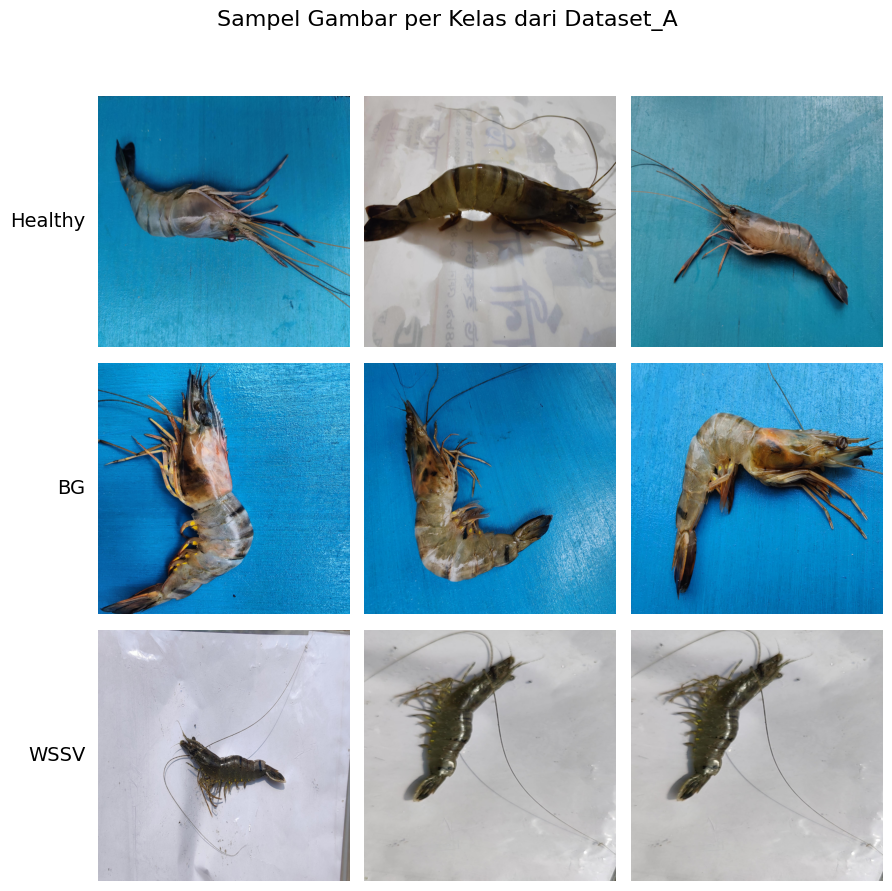


Memuat dan menampilkan sampel gambar dari Dataset_B...


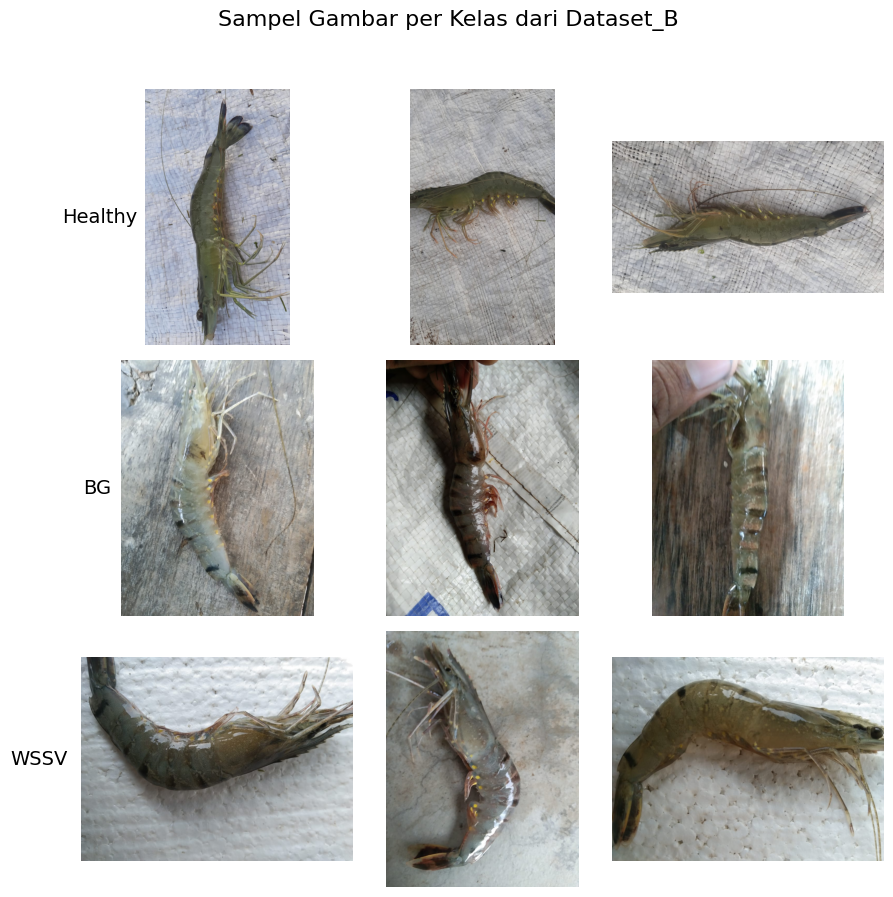


Visualisasi sampel gambar selesai


In [ ]:
# Cell 5: Visualisasi Sampel Gambar dari Data Asli

print("\n" + "="*30)
print("Cell 5: Visualisasi Sampel Gambar dari Data Asli")
print("="*30)

# --- Pastikan CONFIG Sudah Ada ---
if 'CONFIG' not in globals():
    print("ERROR: Variabel CONFIG belum terdefinisi. Jalankan cell definisi CONFIG terlebih dahulu!")
    # Hentikan eksekusi atau berikan default jika CONFIG sangat krusial
    raise NameError("CONFIG is not defined. Please define it in a preceding cell.")

# --- Fungsi Pengambilan Sampel Gambar (Menggunakan CONFIG) ---
def load_sample_images_from_config(dataset_name, config_dict): # Menggunakan config_dict
    """Memuat sampel gambar dari dataset tertentu berdasarkan CONFIG."""
    
    base_path_original = config_dict.get('base_original_data_dir')
    class_map_original_from_config = config_dict.get('class_map_raw', {}) # Diubah nama variabelnya
    n_samples = config_dict.get('viz_n_samples_per_class', 3) # Jumlah sampel dari CONFIG

    if not base_path_original:
        print("ERROR: 'base_original_data_dir' tidak ada di CONFIG. Tidak dapat memuat sampel.")
        return {class_name: [] for class_name in class_map_original_from_config.values()}

    dataset_path = os.path.join(base_path_original, dataset_name)
    # Inisialisasi sample_images berdasarkan nilai (nama kelas bersih) dari class_map_original_from_config
    sample_images = {clean_name: [] for clean_name in class_map_original_from_config.values()}
    
    if not os.path.isdir(dataset_path):
        print(f"Warning: Direktori dataset untuk sampel tidak ditemukan - {dataset_path}")
        return sample_images

    for folder_name_raw, class_label_clean in class_map_original_from_config.items():
        class_path = os.path.join(dataset_path, folder_name_raw) # Gunakan folder_name_raw untuk path
        if os.path.isdir(class_path):
            image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            if not image_files:
                print(f"Info: Tidak ada gambar ditemukan di {class_path} untuk dataset {dataset_name}")
                continue
            
            # Ambil sampel acak
            selected_files = random.sample(image_files, min(n_samples, len(image_files)))
            
            for img_file in selected_files:
                img_path = os.path.join(class_path, img_file)
                try:
                    img = cv2.imread(img_path)
                    if img is None:
                        print(f"Warning: Gagal membaca sampel gambar {img_path} (cv2.imread mengembalikan None)")
                        continue
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Konversi ke RGB
                    sample_images[class_label_clean].append(img) # Simpan dengan nama kelas bersih
                except Exception as e:
                    print(f"Error saat memproses sampel gambar {img_path}: {e}")
        else:
            print(f"Warning: Direktori kelas mentah tidak ditemukan - {class_path}")
            
    # Pastikan semua kelas yang diharapkan ada di sample_images, meskipun kosong
    # Ini berguna jika class_map_raw memiliki lebih banyak entri daripada yang benar-benar ada foldernya
    for expected_clean_label in config_dict.get('valid_class_names', []):
        if expected_clean_label not in sample_images:
            sample_images[expected_clean_label] = []
            
    return sample_images

# --- Fungsi Menampilkan Sampel Gambar (Menggunakan CONFIG) ---
def show_sample_images_configured(images_dict, dataset_name_display, config_dict): # Menggunakan config_dict
    """Menampilkan sampel gambar dengan urutan dan jumlah sampel dari CONFIG."""

    class_names_ordered = config_dict.get('valid_class_names', list(images_dict.keys())) # Urutan kelas dari CONFIG
    n_samples_to_show = config_dict.get('viz_n_samples_per_class', 3) # Jumlah sampel dari CONFIG
    n_classes = len(class_names_ordered)
    
    has_images = any(images_dict.get(cls) for cls in class_names_ordered if images_dict.get(cls))
    if not has_images:
        print(f"Tidak ada sampel gambar untuk ditampilkan dari {dataset_name_display}.")
        return

    # Pengaturan ukuran figure bisa juga dari CONFIG
    figsize_multiplier = config_dict.get('viz_sample_img_figsize_multiplier', 3)
    figsize_y_adjust = config_dict.get('viz_sample_img_figsize_y_adjust', 3.2)
    
    fig, axes = plt.subplots(n_classes, n_samples_to_show, 
                             figsize=(n_samples_to_show * figsize_multiplier, n_classes * figsize_y_adjust),
                             squeeze=False) # Selalu buat 2D array agar konsisten

    suptitle_fontsize = config_dict.get('viz_sample_img_suptitle_fontsize', 16)
    label_fontsize = config_dict.get('viz_sample_img_label_fontsize', 14)

    fig.suptitle(f'Sampel Gambar per Kelas dari {dataset_name_display}', fontsize=suptitle_fontsize, y=0.93) # y disesuaikan

    for class_idx, class_label in enumerate(class_names_ordered):
        for sample_idx in range(n_samples_to_show):
            current_ax = axes[class_idx, sample_idx] # Akses langsung karena axes selalu 2D
            current_ax.axis('off')
            
            # Ambil gambar jika ada
            images_for_class = images_dict.get(class_label, [])
            if sample_idx < len(images_for_class):
                current_ax.imshow(images_for_class[sample_idx])
            
            if sample_idx == 0: # Tampilkan label kelas hanya di kolom pertama
                current_ax.text(-0.05, 0.5, class_label, fontsize=label_fontsize, 
                                va='center', ha='right', transform=current_ax.transAxes)
    
    plt.tight_layout(rect=[0, 0, 1, 0.90]) # Sesuaikan rect untuk suptitle
    plt.show()
    
# --- Proses Utama Visualisasi Sampel (Menggunakan CONFIG) ---
# Mengambil daftar sumber dataset dari CONFIG
dataset_sources_to_visualize = CONFIG.get('dataset_sources', []) # Default ke list kosong jika tidak ada

if not dataset_sources_to_visualize:
    print("Tidak ada 'dataset_sources' yang didefinisikan di CONFIG untuk visualisasi sampel.")
else:
    for dataset_name in dataset_sources_to_visualize:
        print(f"\nMemuat dan menampilkan sampel gambar dari {dataset_name}...")
        # Fungsi load_sample_images_original diganti dengan versi yang menggunakan CONFIG
        sample_images_data = load_sample_images_from_config(dataset_name, CONFIG)
        
        # Fungsi show_sample_images_original diganti dengan versi yang menggunakan CONFIG
        show_sample_images_configured(sample_images_data, dataset_name, CONFIG)

print("\nVisualisasi sampel gambar selesai")

In [7]:
# Cell 5: Definisi Fungsi Augmentasi (Albumentations)
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2 # Pastikan cv2 diimpor jika digunakan untuk interpolation atau border_mode

print("\n" + "="*30)
print("Cell 5: Definisi Fungsi Augmentasi")
print("="*30)

# Pastikan CONFIG sudah terdefinisi dari cell sebelumnya
if 'CONFIG' not in globals() or not isinstance(CONFIG, dict):
    print("ERROR: Variabel CONFIG belum terdefinisi atau bukan dictionary.")
    print("Harap definisikan CONFIG di cell sebelumnya dengan parameter augmentasi yang diperlukan.")
    # Bisa menghentikan eksekusi di sini atau mendefinisikan CONFIG darurat
    # raise NameError("CONFIG is not defined or is not a dictionary.")
    # Contoh CONFIG darurat (tidak direkomendasikan untuk alur kerja utama):
    # CONFIG = {
    #     'TARGET_SIZE': 224, 'IMAGENET_MEAN': [0.485, 0.456, 0.406], 
    #     'IMAGENET_STD': [0.229, 0.224, 0.225],
    #     # Tambahkan parameter aug lainnya dengan nilai default jika CONFIG tidak ada
    # }

def get_train_transform_combined_from_config(config_dict):
    """Membuat pipeline augmentasi training menggunakan parameter dari config_dict."""
    target_size = config_dict.get('TARGET_SIZE', 224) # Fallback jika tidak ada di config

    return A.Compose([
        A.RandomResizedCrop(height=target_size, width=target_size,
                            scale=config_dict.get('aug_train_rr_crop_scale', (0.6, 1.0)),
                            ratio=config_dict.get('aug_train_rr_crop_ratio', (0.75, 1.33)),
                            interpolation=cv2.INTER_AREA, p=1.0),
        A.HorizontalFlip(p=config_dict.get('aug_train_hflip_p', 0.5)),
        A.VerticalFlip(p=config_dict.get('aug_train_vflip_p', 0.3)),
        A.ShiftScaleRotate(shift_limit=config_dict.get('aug_train_ssr_shift', 0.06),
                           scale_limit=config_dict.get('aug_train_ssr_scale', 0.1),
                           rotate_limit=config_dict.get('aug_train_ssr_rotate', 35),
                           interpolation=cv2.INTER_LINEAR, # cv2.INTER_LINEAR lebih umum untuk SSR
                           border_mode=cv2.BORDER_REFLECT_101,
                           p=config_dict.get('aug_train_ssr_p', 0.7)),
        A.ColorJitter(brightness=config_dict.get('aug_train_cj_brightness', 0.25),
                      contrast=config_dict.get('aug_train_cj_contrast', 0.25),
                      saturation=config_dict.get('aug_train_cj_saturation', 0.25),
                      hue=config_dict.get('aug_train_cj_hue', 0.05),
                      p=config_dict.get('aug_train_cj_p', 0.75)),
        A.HueSaturationValue(hue_shift_limit=config_dict.get('aug_train_hsv_hue', 15),
                             sat_shift_limit=config_dict.get('aug_train_hsv_sat', 25),
                             val_shift_limit=config_dict.get('aug_train_hsv_val', 15),
                             p=config_dict.get('aug_train_hsv_p', 0.5)),
        A.CLAHE(clip_limit=config_dict.get('aug_train_clahe_clip', (1, 4)),
                tile_grid_size=config_dict.get('aug_train_clahe_tile', (8, 8)),
                p=config_dict.get('aug_train_clahe_p', 0.5)),
        A.RandomGamma(gamma_limit=config_dict.get('aug_train_gamma_limit', (80, 120)),
                      p=config_dict.get('aug_train_gamma_p', 0.3)),
        A.CoarseDropout(max_holes=config_dict.get('aug_train_dropout_max_holes', 10),
                        max_height=int(target_size * config_dict.get('aug_train_dropout_max_h_factor', 0.1)),
                        max_width=int(target_size * config_dict.get('aug_train_dropout_max_w_factor', 0.1)),
                        min_holes=config_dict.get('aug_train_dropout_min_holes', 1),
                        min_height=int(target_size * config_dict.get('aug_train_dropout_min_h_factor', 0.05)),
                        min_width=int(target_size * config_dict.get('aug_train_dropout_min_w_factor', 0.05)),
                        fill_value=0,
                        p=config_dict.get('aug_train_dropout_p', 0.5)),
        A.Normalize(mean=config_dict.get('IMAGENET_MEAN', [0.485, 0.456, 0.406]),
                    std=config_dict.get('IMAGENET_STD', [0.229, 0.224, 0.225])),
        ToTensorV2()
    ])

def get_valid_transform_from_config(config_dict):
    """Membuat pipeline augmentasi validasi/test menggunakan parameter dari config_dict."""
    target_size = config_dict.get('TARGET_SIZE', 224) # Fallback
    val_resize_size = config_dict.get('aug_val_resize_size', 256) # Fallback

    return A.Compose([
        A.Resize(val_resize_size, val_resize_size, # Menggunakan val_resize_size
                 interpolation=cv2.INTER_AREA),
        A.CenterCrop(target_size, target_size), # Crop ke target_size
        A.Normalize(mean=config_dict.get('IMAGENET_MEAN', [0.485, 0.456, 0.406]),
                    std=config_dict.get('IMAGENET_STD', [0.229, 0.224, 0.225])),
        ToTensorV2()
    ])

# Konfirmasi bahwa fungsi telah didefinisikan
print("Fungsi augmentasi get_train_transform_combined_from_config() dan get_valid_transform_from_config() telah didefinisikan.")
print("Fungsi-fungsi ini akan menggunakan parameter dari CONFIG jika CONFIG dilewatkan sebagai argumen.")


Cell 5: Definisi Fungsi Augmentasi
Fungsi augmentasi get_train_transform_combined_from_config() dan get_valid_transform_from_config() telah didefinisikan.
Fungsi-fungsi ini akan menggunakan parameter dari CONFIG jika CONFIG dilewatkan sebagai argumen.


In [13]:
# Cell 6: Definisi Kelas ShrimpDataset
class ShrimpDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None, target_size_override=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        
        # Logika untuk menentukan self.target_size
        if target_size_override is not None:
            self.target_size = target_size_override
            # Pesan ini sudah cukup baik sebagai indikasi sukses dengan override
            print(f"INFO [ShrimpDataset init]: Menggunakan target_size_override: {self.target_size} untuk {len(self.image_paths)} item.")
        elif 'CONFIG' in globals() and 'TARGET_SIZE' in CONFIG:
            self.target_size = CONFIG['TARGET_SIZE']
            # Pesan ini sudah cukup baik sebagai indikasi sukses dengan CONFIG
            print(f"INFO [ShrimpDataset init]: Menggunakan TARGET_SIZE dari CONFIG: {self.target_size} untuk {len(self.image_paths)} item.")
        else:
            self.target_size = 224 # Nilai default absolut jika semua gagal
            print(f"WARNING [ShrimpDataset init]: target_size tidak ditemukan di argumen maupun CONFIG. Menggunakan default absolut: {self.target_size} untuk {len(self.image_paths)} item.")

        # Pesan sukses inisialisasi yang lebih umum bisa ditambahkan di sini jika mau,
        # tapi print di atas sudah cukup informatif.
        # print(f"DEBUG [ShrimpDataset init]: Inisialisasi ShrimpDataset selesai. Jumlah item: {len(self.image_paths)}, Target size: {self.target_size}")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        
        # Tambahkan os.getpid() untuk debugging multiprocessing jika diperlukan
        # current_process_id = os.getpid() 
        # print(f"DEBUG [Dataset __getitem__ ({current_process_id}-{idx})]: Mulai memproses: {img_path}") 
        
        try:
            image = cv2.imread(img_path)
            if image is None:
                print(f"ERROR DEBUG [Dataset __getitem__ ({idx})]: Gagal membaca gambar (cv2.imread mengembalikan None): {img_path}")
                return torch.randn(3, self.target_size, self.target_size), torch.tensor(-1, dtype=torch.long) 
            
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            # print(f"DEBUG [Dataset __getitem__ ({idx})]: Gambar {img_path} berhasil dimuat, shape awal: {image.shape}")
        except Exception as e_load:
            print(f"ERROR DEBUG [Dataset __getitem__ ({idx})]: Exception saat memuat gambar {img_path}: {e_load}")
            return torch.randn(3, self.target_size, self.target_size), torch.tensor(-1, dtype=torch.long)

        if self.transform:
            # print(f"DEBUG [Dataset __getitem__ ({idx})]: Menerapkan augmentasi pada {img_path}")
            try:
                augmented = self.transform(image=image) # Asumsi transform adalah dari Albumentations
                image = augmented['image']
                # print(f"DEBUG [Dataset __getitem__ ({idx})]: Augmentasi selesai untuk {img_path}, shape baru: {image.shape}")
            except Exception as e_aug:
                print(f"ERROR DEBUG [Dataset __getitem__ ({idx})]: Gagal saat augmentasi {img_path}: {e_aug}")
                return torch.randn(3, self.target_size, self.target_size), torch.tensor(-1, dtype=torch.long)
        else:
            print(f"WARNING DEBUG [Dataset __getitem__ ({idx})]: Tidak ada transform yang diterapkan pada {img_path}. Pastikan output adalah tensor yang sesuai.")
            # Jika tidak ada transform, mungkin perlu menambahkan konversi dasar ke tensor di sini
            # Contoh:
            # if not isinstance(image, torch.Tensor):
            #     # perlu Resize di sini juga jika ukuran belum sesuai
            #     image_pil = Image.fromarray(image) # Jika image adalah numpy array
            #     image_tensor_transform = transforms.Compose([
            #         transforms.Resize((self.target_size, self.target_size)),
            #         transforms.ToTensor()
            #     ])
            #     image = image_tensor_transform(image_pil)


        return image, torch.tensor(label, dtype=torch.long)

# Pesan di akhir cell setelah definisi kelas
print("Definisi kelas ShrimpDataset telah berhasil dimuat/diperbarui.")

Definisi kelas ShrimpDataset telah berhasil dimuat/diperbarui.


In [ ]:
# Cell 7: Fungsi Helper untuk Training dan Validasi per Epoch

def print_text_progress_bar(iteration, total, prefix='', suffix='', decimals=1, length=50, fill='█', print_end="\r"):
    """
    Mencetak progress bar berbasis teks.
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filled_length = int(length * iteration // total)
    bar = fill * filled_length + '-' * (length - filled_length)
    # Tulis ke stdout yang sudah diarahkan oleh Logger
    sys.stdout.write(f'\r{prefix} |{bar}| {percent}% {suffix}')
    sys.stdout.flush()
    if iteration == total:
        sys.stdout.write('\n')
        sys.stdout.flush()

def train_one_epoch(model, train_loader, criterion, optimizer, device, scaler,
                    config_dict, fold_num_display, epoch_num_display,
                    use_tqdm_notebook=False):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    accumulation_steps = config_dict.get('accumulation_steps', 1)
    desc = f"Fold {fold_num_display} Train Epoch {epoch_num_display}"
    
    data_iterator = train_loader
    actual_len_train_loader = len(train_loader)

    if use_tqdm_notebook:
        try:
            from tqdm.notebook import tqdm
            data_iterator = tqdm(enumerate(train_loader), total=actual_len_train_loader, desc=desc, leave=False)
        except ImportError:
            use_tqdm_notebook = False
            data_iterator = enumerate(train_loader)
    else:
        data_iterator = enumerate(train_loader)

    optimizer.zero_grad()
    start_time_epoch = time.time()  # Inisialisasi waktu untuk kalkulasi ETA

    for i, (images, labels) in data_iterator:
        batch_idx_display = i + 1
        images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)

        with amp.autocast(enabled=(device.type == 'cuda')):
            outputs = model(images)
            loss = criterion(outputs, labels)
            if accumulation_steps > 1:
                loss = loss / accumulation_steps
        
        scaler.scale(loss).backward()

        if batch_idx_display % accumulation_steps == 0 or batch_idx_display == actual_len_train_loader:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        running_loss += loss.item() * accumulation_steps * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct_predictions += torch.sum(preds == labels.data)
        total_predictions += labels.size(0)
        
        if use_tqdm_notebook:
            data_iterator.set_postfix(loss=f"{loss.item():.4f}")
        else:
            elapsed_time = time.time() - start_time_epoch
            eta_str = ""
            if i > 0:
                time_per_batch = elapsed_time / (i + 1)
                remaining_batches = actual_len_train_loader - (i + 1)
                eta_seconds = remaining_batches * time_per_batch
                eta_str = f" ETA: {time.strftime('%M:%S', time.gmtime(eta_seconds))}"
            
            suffix_text = f"Loss: {loss.item():.4f}{eta_str}"
            print_text_progress_bar(i + 1, actual_len_train_loader, prefix=f'{desc}:', suffix=suffix_text, length=40)
            
    epoch_loss = running_loss / total_predictions
    epoch_acc = correct_predictions.double() / total_predictions
    
    return epoch_loss, epoch_acc.item()


def validate_one_epoch(model, val_loader, criterion, device, 
                       config_dict, fold_num_display, epoch_num_display,
                       use_tqdm_notebook=False):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    all_labels, all_preds = [], []

    desc = f"Fold {fold_num_display} Val Epoch {epoch_num_display}"
    
    data_iterator = val_loader
    actual_len_val_loader = len(val_loader)

    if use_tqdm_notebook:
        try:
            from tqdm.notebook import tqdm
            data_iterator = tqdm(enumerate(val_loader), total=actual_len_val_loader, desc=desc, leave=False)
        except ImportError:
            use_tqdm_notebook = False
            data_iterator = enumerate(val_loader)
    else:
        data_iterator = enumerate(val_loader)

    start_time_epoch = time.time()  # Inisialisasi waktu untuk kalkulasi ETA

    with torch.no_grad():
        for i, (images, labels) in data_iterator:
            images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct_predictions += torch.sum(preds == labels.data)
            total_predictions += labels.size(0)
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            
            if use_tqdm_notebook:
                data_iterator.set_postfix(loss=f"{loss.item():.4f}")
            else:
                elapsed_time = time.time() - start_time_epoch
                eta_str = ""
                if i > 0:
                    time_per_batch = elapsed_time / (i + 1)
                    remaining_batches = actual_len_val_loader - (i + 1)
                    eta_seconds = remaining_batches * time_per_batch
                    eta_str = f" ETA: {time.strftime('%M:%S', time.gmtime(eta_seconds))}"
                
                suffix_text = f"Loss: {loss.item():.4f}{eta_str}"
                print_text_progress_bar(i + 1, actual_len_val_loader, prefix=f'{desc}:', suffix=suffix_text, length=40)

    epoch_loss = running_loss / total_predictions
    epoch_acc = correct_predictions.double() / total_predictions
    
    return epoch_loss, epoch_acc.item(), np.array(all_labels), np.array(all_preds)


Memeriksa prasyarat untuk visualisasi StratifiedKFold...
Prasyarat terpenuhi, membuat visualisasi StratifiedKFold...

--- Detail Iterasi StratifiedKFold (K=5, SEED=42) ---

  Fold 1:
    Jumlah Data Training: 1087
    Distribusi Kelas Training Fold 1:
      Healthy (ID: 0): 540 sampel (49.68%)
      BG (ID: 1): 135 sampel (12.42%)
      WSSV (ID: 2): 412 sampel (37.90%)
    Jumlah Data Validasi: 272
    Distribusi Kelas Validasi Fold 1:
      Healthy (ID: 0): 135 sampel (49.63%)
      BG (ID: 1): 34 sampel (12.50%)
      WSSV (ID: 2): 103 sampel (37.87%)

  Fold 2:
    Jumlah Data Training: 1087
    Distribusi Kelas Training Fold 2:
      Healthy (ID: 0): 540 sampel (49.68%)
      BG (ID: 1): 135 sampel (12.42%)
      WSSV (ID: 2): 412 sampel (37.90%)
    Jumlah Data Validasi: 272
    Distribusi Kelas Validasi Fold 2:
      Healthy (ID: 0): 135 sampel (49.63%)
      BG (ID: 1): 34 sampel (12.50%)
      WSSV (ID: 2): 103 sampel (37.87%)

  Fold 3:
    Jumlah Data Training: 1087
    Dis

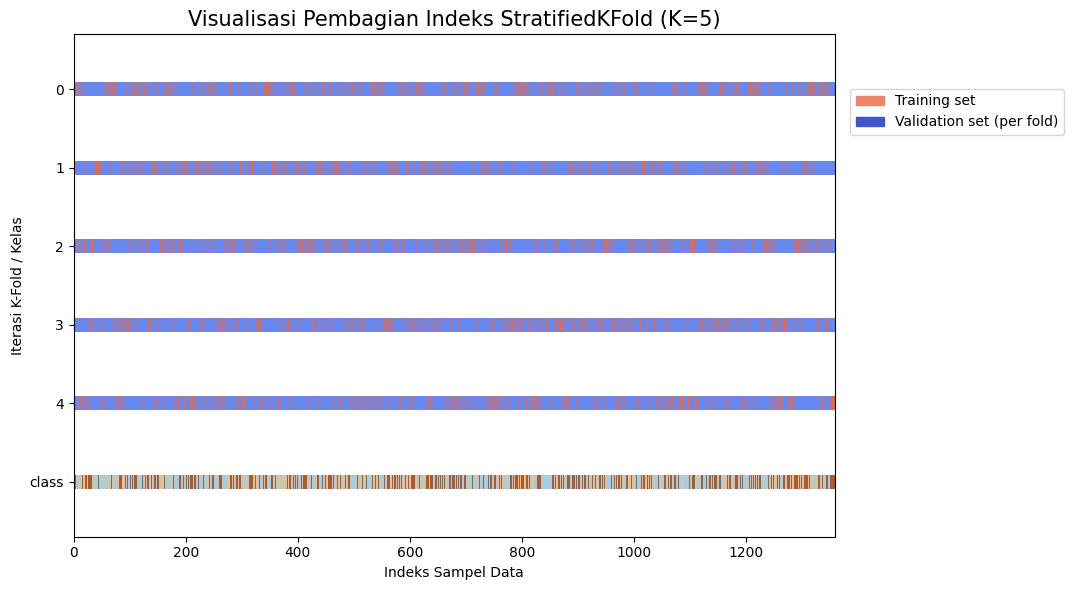

In [ ]:
# Cell 7.1: Visualisasi StratifiedKFold

print("\nMemeriksa prasyarat untuk visualisasi StratifiedKFold...")
if 'X' in globals() and 'y' in globals() and ('X' in globals() and len(X) > 0) and \
   'CONFIG' in globals() and isinstance(CONFIG, dict) and 'num_folds' in CONFIG and \
   'int_to_label' in globals() and isinstance(int_to_label, dict):

    print("Prasyarat terpenuhi, membuat visualisasi StratifiedKFold...")
    n_splits = CONFIG['num_folds']
    # Mengambil SEED dari CONFIG dengan fallback ke SEED global atau nilai default 42
    current_cv_seed = CONFIG.get('SEED', globals().get('SEED', 42)) 
    cv_splitter_obj = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=current_cv_seed)

    print(f"\n--- Detail Iterasi StratifiedKFold (K={n_splits}, SEED={current_cv_seed}) ---")
    for fold_idx, (train_indices, val_indices) in enumerate(cv_splitter_obj.split(X, y)):
        print(f"\n  Fold {fold_idx + 1}:")
        
        y_train_fold = y[train_indices]
        y_val_fold = y[val_indices]

        print(f"    Jumlah Data Training: {len(train_indices)}")
        print(f"    Distribusi Kelas Training Fold {fold_idx + 1}:")
        train_counts = Counter(y_train_fold)
        for label_int, count in sorted(train_counts.items()):
            label_str = int_to_label.get(label_int, f"Unknown_Label_{label_int}")
            percentage = (count / len(y_train_fold)) * 100 if len(y_train_fold) > 0 else 0
            print(f"      {label_str} (ID: {label_int}): {count} sampel ({percentage:.2f}%)")

        print(f"    Jumlah Data Validasi: {len(val_indices)}")
        print(f"    Distribusi Kelas Validasi Fold {fold_idx + 1}:")
        val_counts = Counter(y_val_fold)
        for label_int, count in sorted(val_counts.items()):
            label_str = int_to_label.get(label_int, f"Unknown_Label_{label_int}")
            percentage = (count / len(y_val_fold)) * 100 if len(y_val_fold) > 0 else 0
            print(f"      {label_str} (ID: {label_int}): {count} sampel ({percentage:.2f}%)")
            
    print("--------------------------------------------------\n")

    def plot_cv_indices(cv_splitter, X_data, y_data, ax, n_splits_val, lw=10):
        cmap_data = plt.cm.Paired
        cmap_cv = plt.cm.coolwarm

        for i, (train, test) in enumerate(cv_splitter.split(X_data, y_data)):
            indices = np.array([np.nan] * len(X_data))
            indices[test] = 1
            indices[train] = 0
            ax.scatter(
                range(len(indices)), [i + 0.5] * len(indices),
                c=indices, marker="_", lw=lw, cmap=cmap_cv, vmin=-0.2, vmax=1.2
            )
        ax.scatter(
            range(len(X_data)), [n_splits_val + 0.5] * len(X_data),
            c=y_data, marker="_", lw=lw, cmap=cmap_data
        )
        yticklabels = list(range(n_splits_val)) + ["class"]
        ax.set(
            yticks=np.arange(n_splits_val + 1) + 0.5, yticklabels=yticklabels,
            xlabel="Indeks Sampel Data", ylabel="Iterasi K-Fold / Kelas",
            ylim=[n_splits_val + 1.2, -0.2], xlim=[0, len(X_data)]
        )
        ax.set_title(f"Visualisasi Pembagian Indeks StratifiedKFold (K={n_splits_val})", fontsize=15)
        return ax

    fig, ax = plt.subplots(figsize=(12, 6)) 
    plot_cv_indices(cv_splitter_obj, X, y, ax, n_splits)
    ax.legend(
        [Patch(color=plt.cm.coolwarm(0.8)), Patch(color=plt.cm.coolwarm(0.02))],
        ["Training set", "Validation set (per fold)"], 
        loc=(1.02, 0.8),
    )
    plt.tight_layout()
    fig.subplots_adjust(right=0.7) 
    plt.show()
else:
    print("Pengecekan prasyarat untuk visualisasi StratifiedKFold tidak terpenuhi.")
    print("Pastikan variabel X, y, CONFIG (dengan num_folds dan SEED), dan int_to_label sudah terdefinisi dan valid.")

In [ ]:
# Cell 8: K-Fold Training Utama

# Bagian 1: Setup Logging dengan Timestamp ---
run_timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
print(f"RUN TIMESTAMP: {run_timestamp} (akan digunakan untuk semua file output)")
log_filename = f"training_log_{run_timestamp}.txt"

class Logger(object):
    def __init__(self, filename="Default.log"):
        self.original_stdout = sys.stdout
        self.terminal = sys.stdout
        self.log_file = open(filename, 'w', encoding='utf-8')

    def write(self, message):
        self.terminal.write(message)
        self.log_file.write(message)
        self.flush()

    def flush(self):
        self.terminal.flush()
        self.log_file.flush()
    
    def close(self):
        if self.original_stdout:
             sys.stdout = self.original_stdout
        self.log_file.close()

original_stdout = sys.stdout 
sys.stdout = Logger(log_filename)

print(f"Semua output dari cell ini juga akan disimpan ke file: {log_filename}")
print("-" * 50)

# --- Bagian 2: Loop K-Fold Training Utama ---
try:
    print("\n" + "="*30)
    print("Cell 8: Loop K-Fold Training Utama")
    print("="*30)

    proceed_with_kfold_training = False
    if 'X' in globals() and 'y' in globals() and len(X) > 0 and 'CONFIG' in globals():
        print("Prasyarat terpenuhi. Memulai K-Fold Training...")
        proceed_with_kfold_training = True
    else:
        print("Satu atau lebih variabel prasyarat (X, y, CONFIG) tidak ditemukan atau kosong.")

    if proceed_with_kfold_training:
        current_seed = CONFIG.get('SEED', 42)
        skf = StratifiedKFold(n_splits=CONFIG['num_folds'], shuffle=True, random_state=current_seed)

        fold_results = []
        overall_oof_preds = np.full(len(y), -1, dtype=int) 
        overall_oof_labels = np.full(len(y), -1, dtype=int)  

        model_save_dir = CONFIG.get('model_save_dir', 'models_output') 
        os.makedirs(model_save_dir, exist_ok=True) 

        for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
            fold_num_display = fold + 1
            print(f"\n===== FOLD {fold_num_display}/{CONFIG['num_folds']} =====")

            X_train, X_val = X[train_idx], X[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            
            train_dataset = ShrimpDataset(X_train, y_train, transform=get_train_transform_combined_from_config(CONFIG))
            val_dataset = ShrimpDataset(X_val, y_val, transform=get_valid_transform_from_config(CONFIG))
            train_loader = DataLoader(train_dataset, batch_size=CONFIG['batch_size'], shuffle=True, num_workers=CONFIG.get('num_workers', 0), pin_memory=True)
            val_loader = DataLoader(val_dataset, batch_size=CONFIG.get('val_batch_size', CONFIG['batch_size']*2), shuffle=False, num_workers=CONFIG.get('num_workers', 0), pin_memory=True)

            model = timm.create_model(CONFIG['model_name'], pretrained=True, num_classes=CONFIG['num_classes']).to(device)
            optimizer = getattr(optim, CONFIG['optimizer_name'])(model.parameters(), lr=CONFIG['lr'], weight_decay=CONFIG.get('weight_decay', 0.0))
            
            if CONFIG.get('use_class_weights', True):
                train_class_counts = np.bincount(y_train, minlength=CONFIG['num_classes'])
                class_weights = sum(train_class_counts) / (train_class_counts + 1e-6)
                class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)
                criterion_train = nn.CrossEntropyLoss(weight=class_weights_tensor)
                print(f"INFO: Class weights diaktifkan untuk Fold {fold_num_display}. Bobot: {class_weights_tensor.cpu().numpy()}")
            else:
                criterion_train = nn.CrossEntropyLoss()
            
            criterion_val = nn.CrossEntropyLoss()
            
            scheduler = None
            warmup_epochs = 0
            scheduler_choice = CONFIG.get('scheduler_name')
            if scheduler_choice in ['cosine', 'CosineAnnealingLR']:
                warmup_epochs = CONFIG.get('scheduler_warmup_epochs', 3)
                cosine_t_max = CONFIG['max_epochs_per_fold'] - warmup_epochs
                scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=cosine_t_max if cosine_t_max > 0 else 1, eta_min=CONFIG.get('eta_min_cosine', 1e-7))
                print(f"INFO: Scheduler 'CosineAnnealingLR' diaktifkan dengan {warmup_epochs} epoch warmup.")
            
            scaler = amp.GradScaler(enabled=(device.type == 'cuda'))
            
            best_fold_val_loss = float('inf')
            patience_counter = 0
            fold_history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
            best_model_path_for_fold = None
            best_epoch_oof_preds_for_fold = np.array([])
            best_epoch_oof_labels_for_fold = np.array([])

            for epoch in range(CONFIG['max_epochs_per_fold']):
                epoch_num_display_loop = epoch + 1
                start_time_epoch = time.time()

                if warmup_epochs > 0 and epoch < warmup_epochs and scheduler_choice in ['cosine', 'CosineAnnealingLR']:
                    lr_scale = (epoch + 1) / warmup_epochs
                    for param_group in optimizer.param_groups:
                        param_group['lr'] = CONFIG['lr'] * lr_scale
                
                # --- Panggilan dengan Progress Bar Kustom ---
                train_loss, train_acc = train_one_epoch(model, train_loader, criterion_train, optimizer, device, scaler, CONFIG, fold_num_display, epoch_num_display_loop, use_tqdm_notebook=False)
                val_loss, val_acc, epoch_val_labels_np, epoch_val_preds_np = validate_one_epoch(model, val_loader, criterion_val, device, CONFIG, fold_num_display, epoch_num_display_loop, use_tqdm_notebook=False)
                
                epoch_duration = time.time() - start_time_epoch
                current_lr = optimizer.param_groups[0]['lr'] 

                timestamp_str = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
                print(f"[{timestamp_str}] Epoch {epoch_num_display_loop:02d}/{CONFIG['max_epochs_per_fold']} - "
                      f"Time: {epoch_duration:.2f}s - LR: {current_lr:.1e} - "
                      f"Train Loss: {train_loss:.4f} - Train Acc: {train_acc:.4f} - "
                      f"Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.4f}")

                fold_history['train_loss'].append(train_loss)
                fold_history['train_acc'].append(train_acc)
                fold_history['val_loss'].append(val_loss)
                fold_history['val_acc'].append(val_acc)
                
                if scheduler and epoch >= warmup_epochs:
                    scheduler.step()

                if val_loss < best_fold_val_loss:
                    best_fold_val_loss = val_loss
                    model_filename = f'best_model_fold_{fold_num_display}_{run_timestamp}.pth'
                    model_path = os.path.join(model_save_dir, model_filename)
                    torch.save(model.state_dict(), model_path)
                    best_model_path_for_fold = model_path
                    best_epoch_oof_preds_for_fold = epoch_val_preds_np
                    best_epoch_oof_labels_for_fold = epoch_val_labels_np
                    
                    timestamp_str = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
                    print(f"[{timestamp_str}]   -> Model terbaik Fold {fold_num_display} disimpan. Val Loss: {best_fold_val_loss:.4f}")
                    
                    patience_counter = 0
                else:
                    patience_counter += 1

                if patience_counter >= CONFIG.get('early_stopping_patience', 5):
                    timestamp_str = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
                    print(f"[{timestamp_str}] Early stopping dipicu di epoch {epoch_num_display_loop}.")
                    break
            
            if len(val_idx) > 0 and len(best_epoch_oof_preds_for_fold) == len(val_idx):
                overall_oof_preds[val_idx] = best_epoch_oof_preds_for_fold
                overall_oof_labels[val_idx] = best_epoch_oof_labels_for_fold

            fold_results.append({
                'fold': fold_num_display, 'best_val_loss': best_fold_val_loss,
                'best_val_accuracy': float(fold_history['val_acc'][np.argmin(fold_history['val_loss'])]) if fold_history['val_loss'] else 0.0,
                'history': fold_history, 'model_path': best_model_path_for_fold
            })

        print(f"\n[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] K-Fold Training Selesai.")
        
        # ... (Sisa kode untuk menyimpan hasil JSON dan OOF tetap sama) ...

finally:
    if isinstance(sys.stdout, Logger):
        timestamp_str = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        print(f"\n[{timestamp_str}] Menutup file log.")
        sys.stdout.close()
    print(f"Eksekusi Cell 8 selesai. Log tersimpan di {log_filename}")

RUN TIMESTAMP: 20250608_152646 (akan digunakan untuk semua file output)
Semua output dari cell ini juga akan disimpan ke file: training_log_20250608_152646.txt
--------------------------------------------------

Cell 8: Loop K-Fold Training Utama
Prasyarat terpenuhi. Memulai K-Fold Training...

===== FOLD 1/5 =====
INFO [ShrimpDataset init]: Menggunakan TARGET_SIZE dari CONFIG: 224 untuk 1087 item.
INFO [ShrimpDataset init]: Menggunakan TARGET_SIZE dari CONFIG: 224 untuk 272 item.
INFO: Class weights diaktifkan untuk Fold 1. Bobot: [2.012963  8.051852  2.6383495]
INFO: Scheduler 'CosineAnnealingLR' diaktifkan dengan 3 epoch warmup.
Fold 1 Train Epoch 1: |████████████████████████████████████████| 100.0% Loss: 0.1698 ETA: 00:00
Fold 1 Val Epoch 1: |████████████████████████████████████████| 100.0% Loss: 0.6128 ETA: 00:00
[2025-06-08 15:27:47] Epoch 01/15 - Time: 59.59s - LR: 1.0e-05 - Train Loss: 0.9340 - Train Acc: 0.6173 - Val Loss: 0.7010 - Val Acc: 0.7831
[2025-06-08 15:27:47]   -> Mo

In [ ]:
# Pengecekan Variabel Prasyarat untuk Cell 9.1, 9.2 dan Cell 10 
proceed_with_analysis = False
if 'X' not in globals() or 'y' not in globals() or ('X' in globals() and len(X) == 0): # Cek juga len(X) jika X ada
    print("Variabel X atau y untuk K-Fold (dari df_development) belum terdefinisi atau kosong.")
    print("Pastikan Cell 3 telah dijalankan dengan benar dan memisahkan df_development.")
elif 'CONFIG' not in globals():
    print("Variabel CONFIG belum terdefinisi. Jalankan Cell 6 terlebih dahulu.")
elif 'fold_results' not in globals() or not fold_results:
    print("Variabel 'fold_results' tidak ditemukan atau kosong. Jalankan Cell 8 (K-Fold Training) terlebih dahulu.")
elif 'overall_oof_preds' not in globals() or 'overall_oof_labels' not in globals():
    print("Variabel 'overall_oof_preds' atau 'overall_oof_labels' tidak ditemukan. Pastikan Cell 8 mengisinya.")
elif 'df_all_original_global' not in globals() or df_all_original_global.empty: # df_all_original_global dibutuhkan untuk int_to_label
    print("Variabel 'df_all_original_global' tidak ditemukan atau kosong. Jalankan Cell 3 terlebih dahulu.")
elif 'int_to_label' not in globals():
    print("Variabel 'int_to_label' tidak ditemukan. Jalankan Cell 3 terlebih dahulu.")
else:
    print("Variabel yang dibutuhkan untuk Cell 9.1, 9.2 dan Cell 10 tersedia.")
    proceed_with_analysis = True

Variabel yang dibutuhkan untuk Cell 9.1, 9.2 dan Cell 10 tersedia.



Cell 9.1: Analisis Agregat Hasil K-Fold
Menggunakan variabel 'fold_results' dari memori...

Hasil Rata-rata K-Fold (5 folds):
  Rata-rata Best Validation Loss    : 0.0595
  Rata-rata Best Validation Accuracy: 0.9794 +/- 0.0044

Ringkasan Performa per Fold
 Fold Best Validation Loss Best Validation Accuracy
    1               0.0757                   0.9743
    2               0.0492                   0.9816
    3               0.0411                   0.9853
    4               0.0592                   0.9816
    5               0.0726                   0.9742


Plotting histori training/validasi per fold...


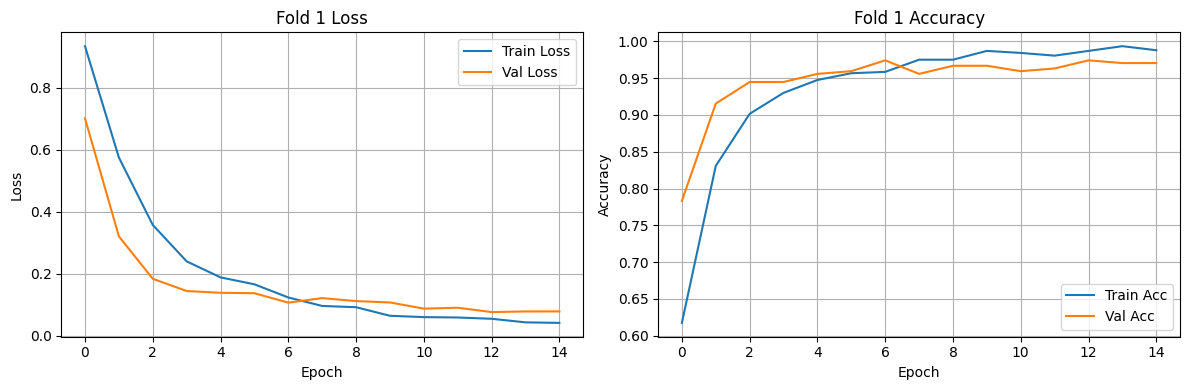

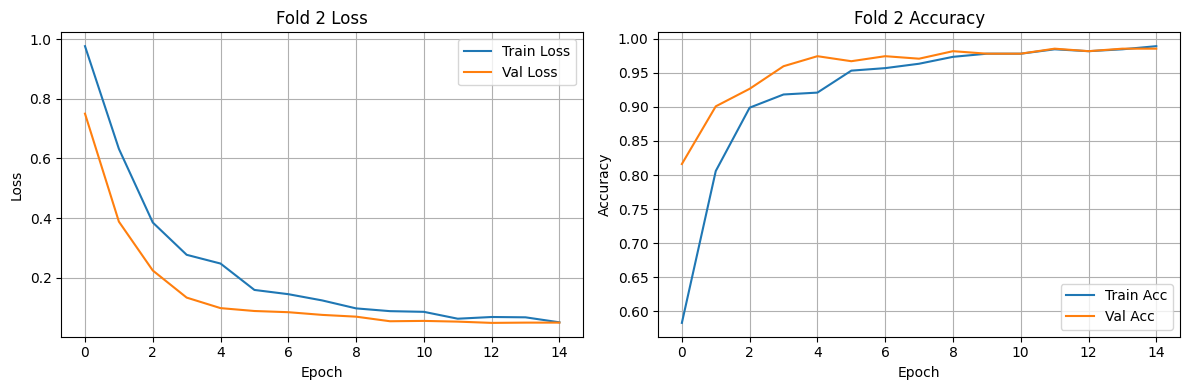

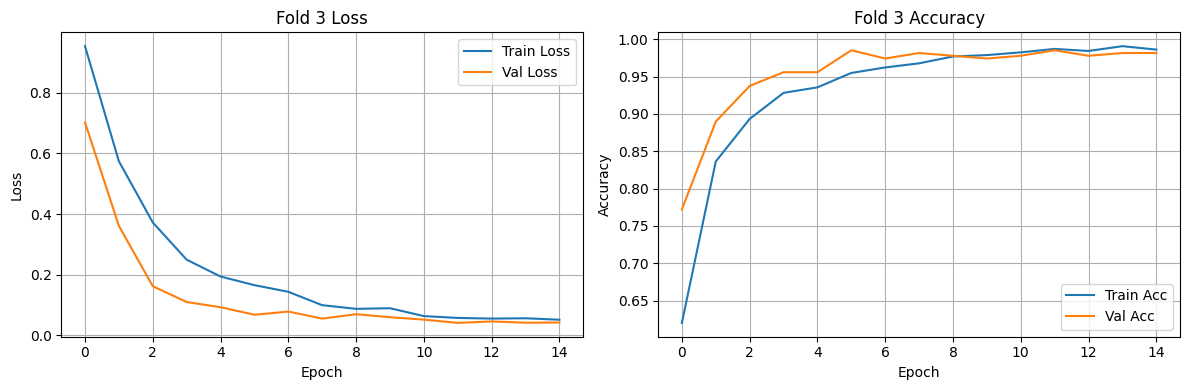

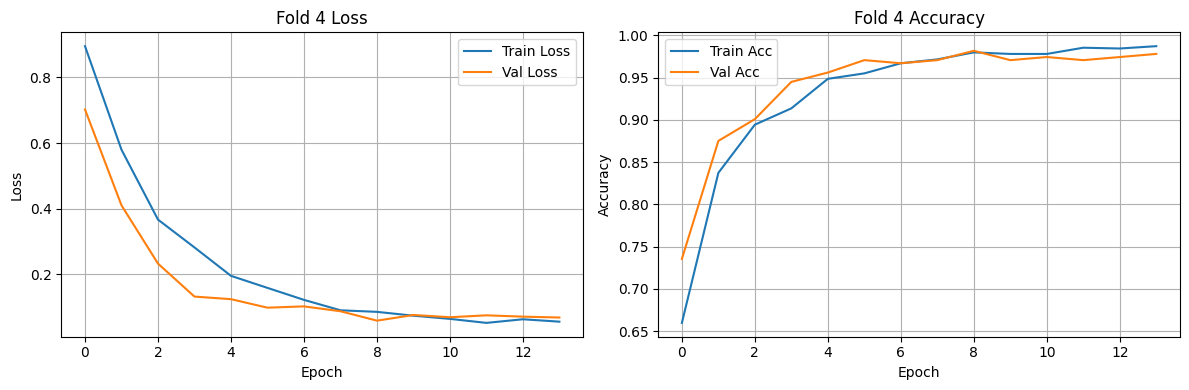

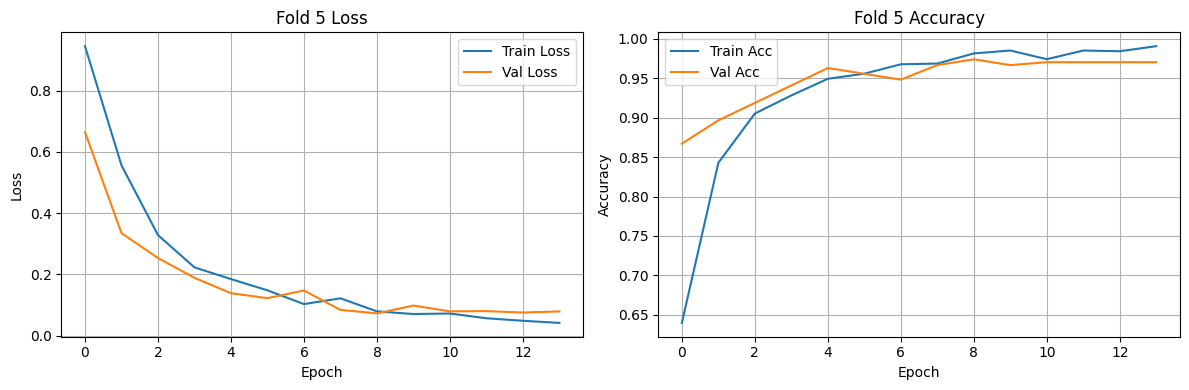

In [ ]:
# Cell 9.1: Analisis Hasil K-Fold

print("\n" + "="*30)
print("Cell 9.1: Analisis Agregat Hasil K-Fold")
print("="*30)

# Logika Cerdas untuk Memuat Data 
results_to_analyze = None
# Prioritas 1: Coba gunakan variabel dari memori
if 'fold_results' in globals() and isinstance(fold_results, list) and fold_results:
    print("Menggunakan variabel 'fold_results' dari memori...")
    results_to_analyze = fold_results
else:
    # Prioritas 2: Jika tidak ada, muat file .json terbaru
    print("Variabel 'fold_results' tidak ditemukan di memori.")
    try:
        # Cari semua file hasil yang cocok dengan pola
        list_of_files = glob.glob('fold_results_summary_*.json')
        if not list_of_files:
            raise FileNotFoundError("Tidak ada file 'fold_results_summary_*.json' yang ditemukan.")
            
        # Dapatkan file terbaru berdasarkan waktu pembuatan
        latest_file = max(list_of_files, key=os.path.getctime)
        print(f"Memuat data dari file JSON terbaru: {latest_file}")
        with open(latest_file, 'r') as f:
            results_to_analyze = json.load(f)
    except Exception as e:
        print(f"ERROR: Gagal memuat data hasil. Error: {e}")

# Lanjutkan hanya jika data berhasil didapatkan
if results_to_analyze:
    # 1. Hitung Metrik Agregat
    avg_val_loss = np.mean([res['best_val_loss'] for res in results_to_analyze])
    avg_val_acc = np.mean([res['best_val_accuracy'] for res in results_to_analyze])
    std_val_acc = np.std([res['best_val_accuracy'] for res in results_to_analyze])

    print(f"\nHasil Rata-rata K-Fold ({len(results_to_analyze)} folds):")
    print(f"  Rata-rata Best Validation Loss    : {avg_val_loss:.4f}")
    print(f"  Rata-rata Best Validation Accuracy: {avg_val_acc:.4f} +/- {std_val_acc:.4f}")

    # Bagian 2: Tampilkan Hasil dalam Bentuk Tabel
    try:
        summary_data = {
            "Fold": [res['fold'] for res in results_to_analyze],
            "Best Validation Loss": [f"{res['best_val_loss']:.4f}" for res in results_to_analyze],
            "Best Validation Accuracy": [f"{res['best_val_accuracy']:.4f}" for res in results_to_analyze]
        }
        summary_df = pd.DataFrame(summary_data)
        print("\n" + "="*30)
        print("Ringkasan Performa per Fold")
        print("="*30)
        # Gunakan to_string() untuk tampilan yang rapi di konsol
        print(summary_df.to_string(index=False))
    except Exception as e_table:
        print(f"\nError saat membuat tabel ringkasan: {e_table}")


    # Bagian 3: Visualisasi Hasil
    print("\n\nPlotting histori training/validasi per fold...")
    for res in results_to_analyze:
        if 'history' in res and res['history']:
            plt.figure(figsize=(12, 4))
            
            # Plot Loss
            plt.subplot(1, 2, 1)
            plt.plot(res['history']['train_loss'], label='Train Loss')
            plt.plot(res['history']['val_loss'], label='Val Loss')
            plt.title(f'Fold {res["fold"]} Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.legend()
            plt.grid(True)

            # Plot Accuracy
            plt.subplot(1, 2, 2)
            plt.plot(res['history']['train_acc'], label='Train Acc')
            plt.plot(res['history']['val_acc'], label='Val Acc')
            plt.title(f'Fold {res["fold"]} Accuracy')
            plt.xlabel('Epoch')
            plt.ylabel('Accuracy')
            plt.legend()
            plt.grid(True)
            
            plt.tight_layout()
            plt.show()
        else:
            print(f"Tidak ada data histori untuk Fold {res['fold']}")
else:
    print("\nAnalisis dilewati karena tidak ada data hasil yang bisa diproses.")


Cell 9.2: Analisis Out-of-Fold (OOF) Predictions

Laporan Klasifikasi Out-of-Fold (OOF):
              precision    recall  f1-score   support

     Healthy       0.98      0.99      0.99       675
          BG       0.94      0.93      0.93       169
        WSSV       0.99      0.98      0.98       515

    accuracy                           0.98      1359
   macro avg       0.97      0.97      0.97      1359
weighted avg       0.98      0.98      0.98      1359


Confusion Matrix Out-of-Fold (OOF) - Jumlah Absolut:


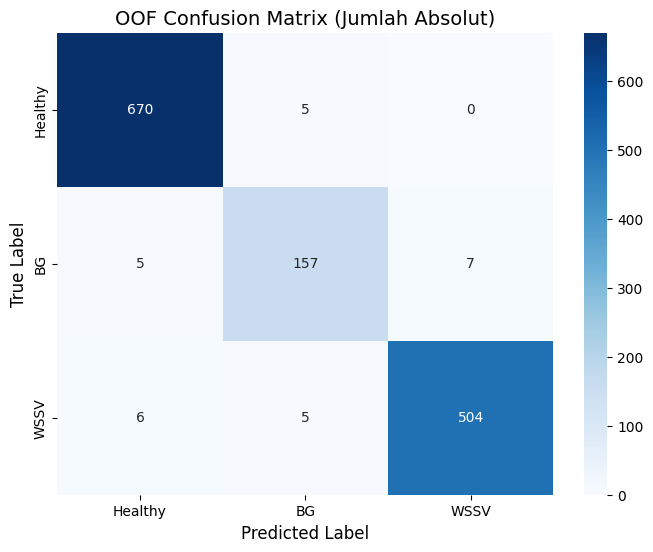


Confusion Matrix Out-of-Fold (OOF) - Normalisasi per True Label (Recall):


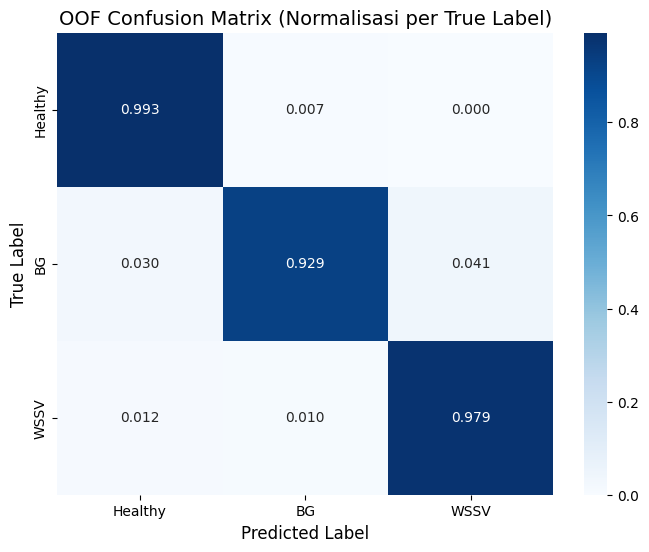

In [ ]:
# Cell 9.2: Analisis Out-of-Fold (OOF) Predictions
if proceed_with_analysis:
    from sklearn.metrics import classification_report, confusion_matrix 
    import seaborn as sns 

    print("\n" + "="*30)
    print("Cell 9.2: Analisis Out-of-Fold (OOF) Predictions")
    print("="*30)

    # Cek apakah ada data OOF yang valid (misalnya, tidak semua -1 atau 0 jika itu nilai default)
    # Menggunakan y (dari df_development) untuk ukuran, karena OOF harusnya seukuran itu
    if 'overall_oof_labels' in globals() and 'overall_oof_preds' in globals() and \
       len(overall_oof_labels) == len(y) and len(overall_oof_preds) == len(y) and \
       (np.any(overall_oof_labels != 0) or np.any(overall_oof_preds != 0) or np.all(overall_oof_labels != -1)):


        sorted_unique_labels_int = sorted(list(int_to_label.keys()))
        oof_class_names = [int_to_label[i] for i in sorted_unique_labels_int]

        print("\nLaporan Klasifikasi Out-of-Fold (OOF):")
        print(classification_report(overall_oof_labels, overall_oof_preds, 
                                    labels=sorted_unique_labels_int, 
                                    target_names=oof_class_names, 
                                    zero_division=0))
        
        print("\nConfusion Matrix Out-of-Fold (OOF) - Jumlah Absolut:")
        cm_oof = confusion_matrix(overall_oof_labels, overall_oof_preds, labels=sorted_unique_labels_int)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm_oof, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=oof_class_names, yticklabels=oof_class_names)
        plt.xlabel('Predicted Label', fontsize=12)
        plt.ylabel('True Label', fontsize=12)
        plt.title('OOF Confusion Matrix (Jumlah Absolut)', fontsize=14)
        plt.show()
        
        print("\nConfusion Matrix Out-of-Fold (OOF) - Normalisasi per True Label (Recall):")
        cm_oof_normalized = confusion_matrix(overall_oof_labels, overall_oof_preds, 
                                             labels=sorted_unique_labels_int, normalize='true')
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm_oof_normalized, annot=True, fmt='.3f', cmap='Blues', 
                    xticklabels=oof_class_names, yticklabels=oof_class_names)
        plt.xlabel('Predicted Label', fontsize=12)
        plt.ylabel('True Label', fontsize=12)
        plt.title('OOF Confusion Matrix (Normalisasi per True Label)', fontsize=14)
        plt.show()
    else:
        print("\nTidak ada prediksi Out-of-Fold (OOF) yang valid untuk dianalisis atau ukurannya tidak sesuai.")
        print("Pastikan Cell 8 (K-Fold Training) telah dijalankan dan mengisi 'overall_oof_labels' serta 'overall_oof_preds' dengan benar dan seukuran data K-Fold.")
else:
    if not proceed_with_analysis:
        print("Analisis OOF dilewati karena variabel prasyarat tidak lengkap.")

In [14]:
# Cell 10: Prediksi Ensemble Learning
# ==============================================================================
# --- Bagian 1: Definisi Fungsi & Widget ---
# ==============================================================================

# Asumsi fungsi-fungsi ini sudah ada dari cell sebelumnya, tapi kita definisikan ulang untuk keamanan
def load_model_for_prediction(config, device, explicit_model_path=None):
    if not explicit_model_path or not os.path.exists(explicit_model_path):
        print(f"ERROR: File model tidak ditemukan di '{explicit_model_path}'")
        return None
    try:
        model = timm.create_model(config['model_name'], pretrained=False, num_classes=config['num_classes'])
        model.load_state_dict(torch.load(explicit_model_path, map_location=device))
        model.to(device)
        model.eval()
        return model
    except Exception as e:
        print(f"ERROR saat memuat model dari '{explicit_model_path}': {e}")
        return None

# Cek prasyarat sebelum membuat UI
proceed_with_ui = False
if 'CONFIG' in globals() and 'get_valid_transform_from_config' in globals() and 'int_to_label' in globals():
    print("Semua prasyarat untuk Prediksi Ensemble terpenuhi.")
    proceed_with_ui = True
else:
    print("PERINGATAN: Variabel prasyarat (CONFIG, get_valid_transform_from_config, atau int_to_label) tidak ditemukan. UI tidak akan dibuat.")

if proceed_with_ui:
    # --- UI Widgets ---
    model_dir_input = widgets.Text(
        value=CONFIG.get('model_save_dir', 'models_output'),
        placeholder='Masukkan path ke folder berisi model .pth',
        description='Model Dir:', style={'description_width': 'initial'}, layout=widgets.Layout(width='90%')
    )
    image_uploader = widgets.FileUpload(
        accept='image/*',
        multiple=False,
        description='Unggah Gambar'
    )
    
    # --- WIDGET BARU: Pilihan Metode Ensemble ---
    ensemble_method_selector = widgets.Dropdown(
        options=['Simple Averaging', 'Weighted Averaging', 'Majority Voting'],
        value='Simple Averaging',
        description='Metode Ensemble:',
        style={'description_width': 'initial'}
    )
    weights_input = widgets.Text(
        value='1.0, 1.0, 1.0',
        placeholder='e.g., 1.0, 1.5, 1.0',
        description='Bobot Kelas:',
        disabled=True # Akan diaktifkan jika 'Weighted Averaging' dipilih
    )
    
    ensemble_button = widgets.Button(
        description="Jalankan Prediksi Ensemble",
        button_style='success',
        icon='cogs'
    )
    ensemble_output_area = widgets.Output()
    
    # --- Fungsi untuk mengontrol UI berdasarkan pilihan metode ---
    def handle_method_change(change):
        weights_input.disabled = (change.new != 'Weighted Averaging')
    ensemble_method_selector.observe(handle_method_change, names='value')

    # --- Fungsi Handler untuk Tombol ---
    def on_ensemble_button_clicked(b):
        with ensemble_output_area:
            clear_output(wait=True)
            print("Memulai proses prediksi ensemble...")

            uploaded_file = image_uploader.value
            base_model_dir = model_dir_input.value.strip()

            if not uploaded_file: print("ERROR: Mohon unggah satu gambar."); return
            if not base_model_dir or not os.path.isdir(base_model_dir): print(f"ERROR: Direktori model '{base_model_dir}' tidak valid."); return

            file_info = uploaded_file[0]
            pil_image = PILImage.open(io.BytesIO(file_info['content'])).convert('RGB')
            
            plt.figure(figsize=(4, 4))
            plt.imshow(pil_image)
            plt.title(f"Gambar Input: {file_info['name']}")
            plt.axis('off')
            plt.show()
            
            all_fold_probs = []
            valid_transform = get_valid_transform_from_config(CONFIG)
            input_tensor = valid_transform(image=np.array(pil_image))['image'].unsqueeze(0).to(device)

            print("\n--- Prediksi per Fold ---")
            for fold_num in range(1, CONFIG.get('num_folds', 5) + 1):
                model_pattern = os.path.join(base_model_dir, f'best_model_fold_{fold_num}_*.pth')
                list_of_models = glob.glob(model_pattern)
                if not list_of_models:
                    print(f"  Fold {fold_num}: Model tidak ditemukan."); continue
                latest_model_path = max(list_of_models, key=os.path.getctime)
                print(f"  Fold {fold_num}: Memuat model -> {os.path.basename(latest_model_path)}")
                model = load_model_for_prediction(CONFIG, device, explicit_model_path=latest_model_path)
                if model:
                    with torch.no_grad():
                        logits = model(input_tensor)
                        probs = torch.softmax(logits, dim=1).cpu().numpy().flatten()
                        all_fold_probs.append(probs)
                        pred_idx = np.argmax(probs)
                        print(f"    -> Prediksi: {int_to_label.get(pred_idx, 'N/A')} ({probs[pred_idx]*100:.2f}%)")

            # --- Langkah 2: Jalankan Logika Ensemble ---
            if len(all_fold_probs) > 0:
                print(f"\n" + "="*40)
                print(f"Hasil Ensemble Learning")
                print(f"="*40)
                
                sorted_labels = sorted(int_to_label.items())
                class_names = [label for idx, label in sorted_labels]
                all_fold_probs_np = np.array(all_fold_probs, dtype=np.float32)
                
                selected_method = ensemble_method_selector.value
                
                if selected_method == 'Majority Voting':
                    print("Metode: Majority Voting (Hard Voting)")
                    fold_predictions = np.argmax(all_fold_probs_np, axis=1)
                    counts = np.bincount(fold_predictions, minlength=len(class_names))
                    predicted_class_idx = np.argmax(counts)
                    predicted_class_label = class_names[predicted_class_idx]
                    ensemble_confidence = counts[predicted_class_idx] / len(fold_predictions)
                    
                    print("\nDistribusi Suara (Votes):")
                    for i, class_name in enumerate(class_names):
                        print(f"  {class_name}: {counts[i]} suara")

                else: # Untuk Simple Averaging dan Weighted Averaging
                    if selected_method == 'Weighted Averaging':
                        try:
                            weights_str = weights_input.value.strip()
                            class_weights = np.array([float(w.strip()) for w in weights_str.split(',')], dtype=np.float32)
                            if len(class_weights) != all_fold_probs_np.shape[1]:
                                print(f"ERROR: Jumlah bobot ({len(class_weights)}) tidak cocok. Fallback ke Simple Averaging.")
                                final_scores = np.mean(all_fold_probs_np, axis=0)
                            else:
                                print(f"Metode: Weighted Averaging dengan bobot {class_weights}")
                                final_scores = np.mean(all_fold_probs_np * class_weights, axis=0)
                        except Exception as e:
                            print(f"ERROR: Format bobot tidak valid. Fallback ke Simple Averaging. Error: {e}")
                            final_scores = np.mean(all_fold_probs_np, axis=0)
                    else: # Simple Averaging
                        print("Metode: Simple Averaging (Soft Voting)")
                        final_scores = np.mean(all_fold_probs_np, axis=0)
                    
                    # Normalisasi skor menjadi probabilitas
                    sum_scores = np.sum(final_scores)
                    normalized_probs = final_scores / sum_scores if sum_scores > 1e-9 else np.ones(len(class_names)) / len(class_names)
                    
                    predicted_class_idx = np.argmax(normalized_probs)
                    predicted_class_label = class_names[predicted_class_idx]
                    ensemble_confidence = normalized_probs[predicted_class_idx]
                    
                    print("\nProbabilitas Rata-rata Ensemble:")
                    for i, class_name in enumerate(class_names):
                        print(f"  {class_name}: {normalized_probs[i]*100:.2f}%")

                print("\n--- Prediksi Akhir Ensemble ---")
                print(f"Hasil: '{predicted_class_label}' dengan keyakinan {ensemble_confidence*100:.2f}%")
            else:
                print("\nERROR: Tidak ada model yang berhasil dimuat.")

    # ensemble_button.on_click(on_ensemble_button_clicked)
    # Hapus handler lama jika ada, untuk mencegah duplikasi
    try:
        ensemble_button.on_click(on_ensemble_button_clicked, remove=True)
    except ValueError:
        pass # Abaikan error jika handler belum pernah ditambahkan sebelumnya

    # Tambahkan handler yang baru
    ensemble_button.on_click(on_ensemble_button_clicked)

    # --- Tampilkan UI ---
    display(widgets.VBox([
        widgets.Label("1. Tentukan Direktori Model:"),
        model_dir_input,
        widgets.Label("2. Pilih Opsi Ensemble & Unggah Gambar:"),
        ensemble_method_selector,
        weights_input,
        image_uploader,
        ensemble_button,
        ensemble_output_area
    ]))

Semua prasyarat untuk Prediksi Ensemble terpenuhi.



Cell 11.2: Evaluasi Ensemble pada Hold-Out Test Set
✅ Menggunakan hold-out test set: hold_out_test_set_asli_20250715_220136.csv

📸 Total gambar di hold-out test: 240
INFO [ShrimpDataset init]: Menggunakan TARGET_SIZE dari CONFIG: 224 untuk 240 item.

--- Memuat Model dan Mengumpulkan Prediksi ---
✅ Fold 1: best_model_fold_1_20250608_152646.pth
✅ Fold 2: best_model_fold_2_20250608_152646.pth
✅ Fold 3: best_model_fold_3_20250608_152646.pth
✅ Fold 4: best_model_fold_4_20250608_152646.pth
✅ Fold 5: best_model_fold_5_20250608_152646.pth

📌 Bobot Kelas (Untuk Weighted Averaging):
  Healthy (class 0): weight = 1.0
  BG (class 1): weight = 1.5
  WSSV (class 2): weight = 1.0

🟢 === [Simple Averaging] ===

📊 Classification Report:
              precision    recall  f1-score   support

     Healthy       0.99      0.99      0.99       119
          BG       0.97      0.97      0.97        30
        WSSV       0.99      0.99      0.99        91

    accuracy                           0.99       

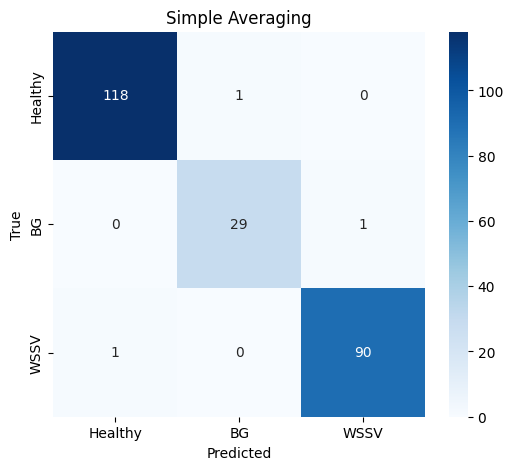


🟡 === [Weighted Averaging] ===

📊 Classification Report:
              precision    recall  f1-score   support

     Healthy       0.99      0.99      0.99       119
          BG       0.97      0.97      0.97        30
        WSSV       0.99      0.99      0.99        91

    accuracy                           0.99       240
   macro avg       0.98      0.98      0.98       240
weighted avg       0.99      0.99      0.99       240


📉 Confusion Matrix:


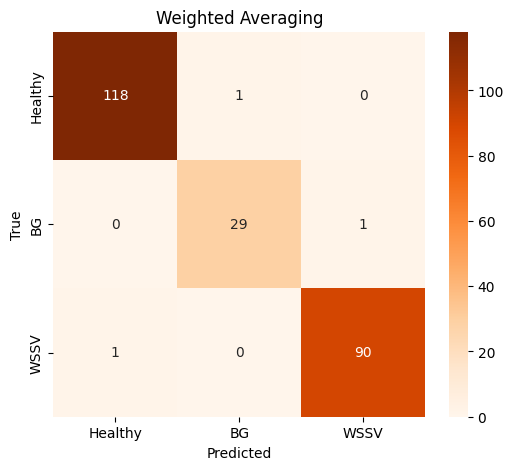


🔵 === [Majority Voting] ===

📊 Classification Report:
              precision    recall  f1-score   support

     Healthy       0.99      0.99      0.99       119
          BG       0.97      0.97      0.97        30
        WSSV       0.99      0.99      0.99        91

    accuracy                           0.99       240
   macro avg       0.98      0.98      0.98       240
weighted avg       0.99      0.99      0.99       240


📉 Confusion Matrix:


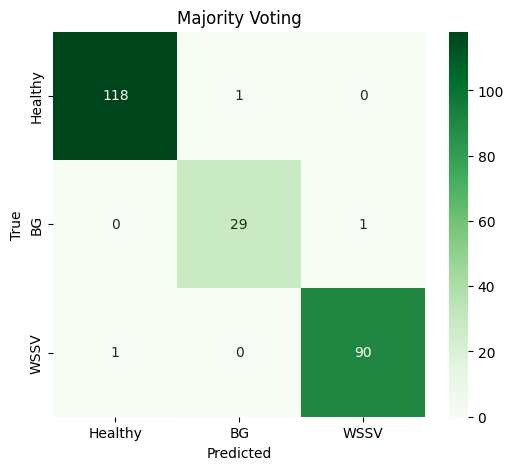

In [16]:
# Cell 11: Evaluasi Ensemble - Simple, Weighted, Majority

from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import DataLoader
import seaborn as sns
import matplotlib.pyplot as plt
import glob, os
import numpy as np

print("\n" + "="*40)
print("Cell 11.2: Evaluasi Ensemble pada Hold-Out Test Set")
print("="*40)

# 1. Pastikan semua variabel penting tersedia
required_vars = ['CONFIG', 'device', 'ShrimpDataset', 'get_valid_transform_from_config', 'int_to_label']
missing_vars = [v for v in required_vars if v not in globals()]
if missing_vars:
    print(f"❌ Evaluasi dibatalkan. Variabel berikut belum tersedia: {missing_vars}")
    proceed_with_hold_out_eval = False
else:
    # Cari file hold-out test set terbaru
    data_split_dir = os.path.join(CONFIG['output_base_dir'], 'data_splits')
    csv_pattern = os.path.join(data_split_dir, 'hold_out_test_set_asli_*.csv')
    csv_files = glob.glob(csv_pattern)

    if not csv_files:
        print(f"❌ Tidak ditemukan file hold_out_test_set_asli_*.csv di {data_split_dir}")
        proceed_with_hold_out_eval = False
    else:
        latest_csv = max(csv_files, key=os.path.getmtime)
        df_hold_out_test = pd.read_csv(latest_csv)
        print(f"✅ Menggunakan hold-out test set: {os.path.basename(latest_csv)}")

        proceed_with_hold_out_eval = not df_hold_out_test.empty

# 2. Proses Evaluasi
if proceed_with_hold_out_eval:
    print(f"\n📸 Total gambar di hold-out test: {len(df_hold_out_test)}")

    hold_out_dataset = ShrimpDataset(
        image_paths=df_hold_out_test['image_path'].values,
        labels=df_hold_out_test['label_int'].values,
        transform=get_valid_transform_from_config(CONFIG)
    )
    hold_out_loader = DataLoader(
        hold_out_dataset,
        batch_size=CONFIG.get('val_batch_size', 16),
        shuffle=False,
        num_workers=CONFIG.get('num_workers', 0)
    )

    # Load model dan prediksi
    all_probs, all_preds = [], []
    model_dir = CONFIG.get('model_save_dir', 'models_output')
    num_folds = CONFIG.get('num_folds', 5)

    print("\n--- Memuat Model dan Mengumpulkan Prediksi ---")
    for fold in range(1, num_folds + 1):
        model_files = glob.glob(os.path.join(model_dir, f'best_model_fold_{fold}_*.pth'))
        if not model_files:
            print(f"❌ Fold {fold}: Model tidak ditemukan.")
            continue

        model_path = max(model_files, key=os.path.getctime)
        print(f"✅ Fold {fold}: {os.path.basename(model_path)}")

        model = timm.create_model(CONFIG['model_name'], pretrained=False, num_classes=CONFIG['num_classes'])
        model.load_state_dict(torch.load(model_path, map_location=device))
        model.to(device)
        model.eval()

        fold_probs, fold_preds = [], []

        with torch.no_grad():
            for images, _ in hold_out_loader:
                images = images.to(device)
                outputs = model(images)
                probs = torch.softmax(outputs, dim=1).cpu()
                preds = torch.argmax(probs, dim=1)

                fold_probs.append(probs)
                fold_preds.append(preds)

        all_probs.append(torch.cat(fold_probs).numpy())
        all_preds.append(torch.cat(fold_preds).numpy())

    if all_probs:
        y_true = df_hold_out_test['label_int'].values
        sorted_labels = sorted(int_to_label.items())
        class_names = [v for _, v in sorted_labels]

        # 💡 Class weights didefinisikan di sini langsung
        class_weights = np.array([1.0, 1.5, 1.0], dtype=np.float32)

        print("\n📌 Bobot Kelas (Untuk Weighted Averaging):")
        for i, (name, weight) in enumerate(zip(class_names, class_weights)):
            print(f"  {name} (class {i}): weight = {weight}")

        all_probs_np = np.array(all_probs)  # (num_models, num_samples, num_classes)
        all_preds_np = np.array(all_preds)  # (num_models, num_samples)

        # === SIMPLE AVERAGING ===
        print("\n🟢 === [Simple Averaging] ===")
        probs_avg = np.mean(all_probs_np, axis=0)
        preds_avg = np.argmax(probs_avg, axis=1)

        print("\n📊 Classification Report:")
        print(classification_report(y_true, preds_avg, target_names=class_names, zero_division=0))
        print("\n📉 Confusion Matrix:")
        plt.figure(figsize=(6,5))
        sns.heatmap(confusion_matrix(y_true, preds_avg), annot=True, fmt='d',
                    cmap='Blues', xticklabels=class_names, yticklabels=class_names)
        plt.title("Simple Averaging")
        plt.xlabel("Predicted"); plt.ylabel("True")
        plt.show()

        # === WEIGHTED AVERAGING ===
        print("\n🟡 === [Weighted Averaging] ===")
        probs_avg_w = np.mean(all_probs_np, axis=0) * class_weights  # apply weights
        probs_avg_w_norm = probs_avg_w / probs_avg_w.sum(axis=1, keepdims=True)  # normalize
        preds_w = np.argmax(probs_avg_w_norm, axis=1)

        print("\n📊 Classification Report:")
        print(classification_report(y_true, preds_w, target_names=class_names, zero_division=0))
        print("\n📉 Confusion Matrix:")
        plt.figure(figsize=(6,5))
        sns.heatmap(confusion_matrix(y_true, preds_w), annot=True, fmt='d',
                    cmap='Oranges', xticklabels=class_names, yticklabels=class_names)
        plt.title("Weighted Averaging")
        plt.xlabel("Predicted"); plt.ylabel("True")
        plt.show()

        # === MAJORITY VOTING ===
        print("\n🔵 === [Majority Voting] ===")
        preds_vote = []
        for col in all_preds_np.T:
            majority = np.bincount(col, minlength=len(class_names)).argmax()
            preds_vote.append(majority)

        print("\n📊 Classification Report:")
        print(classification_report(y_true, preds_vote, target_names=class_names, zero_division=0))
        print("\n📉 Confusion Matrix:")
        plt.figure(figsize=(6,5))
        sns.heatmap(confusion_matrix(y_true, preds_vote), annot=True, fmt='d',
                    cmap='Greens', xticklabels=class_names, yticklabels=class_names)
        plt.title("Majority Voting")
        plt.xlabel("Predicted"); plt.ylabel("True")
        plt.show()

    else:
        print("❌ Tidak ada model yang berhasil dievaluasi.")

In [8]:
# Cell 12: 📷 Grad-CAM

# Impor untuk Grad-CAM (dengan pengecekan)
grad_cam_lib_available = False
AvailableCAMs = {}
try:
    from pytorch_grad_cam import GradCAM, HiResCAM, GradCAMPlusPlus
    from pytorch_grad_cam.utils.image import show_cam_on_image
    from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
    grad_cam_lib_available = True
    AvailableCAMs['GradCAM'] = GradCAM
    AvailableCAMs['HiResCAM'] = HiResCAM
    AvailableCAMs['GradCAMPlusPlus'] = GradCAMPlusPlus
    print("Library pytorch-grad-cam berhasil diimpor.")
except ImportError:
    print("PERINGATAN: Library 'pytorch-grad-cam' tidak terinstal.")

# --- Definisi Fungsi Helper ---
def load_model_for_prediction(config, device, explicit_model_path=None):
    if not explicit_model_path or not os.path.exists(explicit_model_path):
        print(f"ERROR: File model tidak ditemukan di '{explicit_model_path}'")
        return None
    try:
        model = timm.create_model(config['model_name'], pretrained=False, num_classes=config['num_classes'])
        model.load_state_dict(torch.load(explicit_model_path, map_location=device))
        model.to(device)
        model.eval()
        return model
    except Exception as e:
        print(f"ERROR saat memuat model dari '{explicit_model_path}': {e}")
        return None

def reshape_transform_swin(tensor):
    if len(tensor.shape) == 3:
        B, N, C = tensor.shape
        H = W = int(N**0.5)
        if H * W != N: return tensor
        return tensor.reshape(B, H, W, C).permute(0, 3, 1, 2)
    return tensor

# --- Setup UI Grad-CAM Interaktif (Versi Pintar) ---
if 'CONFIG' in globals() and grad_cam_lib_available:
    print("Semua prasyarat untuk Grad-CAM Interaktif terpenuhi.")
    
    # --- UI Widgets ---
    model_dir_input = widgets.Text(
        value=CONFIG.get('model_save_dir', 'models_output'),
        placeholder='Masukkan path ke folder model',
        description='Model Dir:', style={'description_width': 'initial'}, layout=widgets.Layout(width='90%')
    )
    grad_cam_uploader = widgets.FileUpload(accept='image/*', multiple=True, description='Unggah Gambar')
    grad_cam_algorithm_selector = widgets.Dropdown(options=list(AvailableCAMs.keys()), value='GradCAM', description='Algoritma CAM:')
    grad_cam_run_button = widgets.Button(description="Buat Grad-CAM", button_style='info', icon='eye')
    grad_cam_output_area = widgets.Output()

    # --- Fungsi Handler untuk Tombol ---
    def on_grad_cam_run_button_clicked(b):
        with grad_cam_output_area:
            clear_output(wait=True)
            print("Memulai proses Grad-CAM...")

            uploaded_files = grad_cam_uploader.value
            base_model_dir = model_dir_input.value.strip()

            if not uploaded_files: print("ERROR: Mohon unggah setidaknya satu gambar."); return
            if not base_model_dir or not os.path.isdir(base_model_dir): print(f"ERROR: Direktori model '{base_model_dir}' tidak valid."); return

            valid_transform = get_valid_transform_from_config(CONFIG)
            target_size = CONFIG.get('TARGET_SIZE', 224)
            num_folds = CONFIG.get('num_folds', 5)

            for file_info in uploaded_files:
                print(f"\n--- Menganalisis Gambar: {file_info['name']} ---")
                pil_image = PILImage.open(io.BytesIO(file_info['content'])).convert('RGB')
                display_image = cv2.resize(np.array(pil_image), (target_size, target_size))
                overlay_image = np.float32(display_image) / 255.0
                
                # --- PERUBAHAN DI SINI: Membuat subplot vertikal ---
                # Mengubah dari (1, num_folds) menjadi (num_folds, 1)
                # Menyesuaikan figsize agar lebih tinggi daripada lebar
                fig, axes = plt.subplots(num_folds, 1, figsize=(6, num_folds * 5), squeeze=False)
                fig.suptitle(f"Grad-CAM untuk {file_info['name']}", fontsize=16)

                for i in range(num_folds):
                    fold_num = i + 1
                    # --- PERUBAHAN AKSES AXIS DI SINI ---
                    # Mengubah dari axes[0, i] menjadi axes[i, 0]
                    ax = axes[i, 0]
                    
                    # --- LOGIKA PENCARIAN MODEL TERBARU ---
                    model_pattern = os.path.join(base_model_dir, f'best_model_fold_{fold_num}_*.pth')
                    list_of_models = glob.glob(model_pattern)
                    
                    if not list_of_models:
                        ax.imshow(display_image); ax.set_title(f"Fold {fold_num}\nModel Tidak Ditemukan", fontsize=9)
                        ax.axis('off'); continue
                    
                    latest_model_path = max(list_of_models, key=os.path.getctime)
                    print(f"  Fold {fold_num}: Menggunakan model terbaru -> {os.path.basename(latest_model_path)}")
                    
                    model = load_model_for_prediction(CONFIG, device, explicit_model_path=latest_model_path)
                    
                    if model is None:
                        ax.imshow(display_image); ax.set_title(f"Fold {fold_num}\nModel Gagal Dimuat", fontsize=9)
                        ax.axis('off'); continue

                    # (Sisa logika Grad-CAM sama seperti sebelumnya)
                    input_tensor = valid_transform(image=np.array(pil_image))['image'].unsqueeze(0).to(device)
                    with torch.no_grad():
                        logits = model(input_tensor)
                        pred_idx = torch.argmax(logits, dim=1).item()
                        pred_label = int_to_label.get(pred_idx, "N/A")
                        confidence = torch.softmax(logits, dim=1)[0, pred_idx].item()

                    target_layers = [model.layers[-1].blocks[-1].norm2]
                    cam_algorithm = AvailableCAMs[grad_cam_algorithm_selector.value]

                    with cam_algorithm(model=model, target_layers=target_layers, reshape_transform=reshape_transform_swin) as cam:
                        grayscale_cam = cam(input_tensor=input_tensor, targets=[ClassifierOutputTarget(pred_idx)])[0, :]
                        visualization = show_cam_on_image(overlay_image, grayscale_cam, use_rgb=True)
                        ax.imshow(visualization)
                        ax.set_title(f"Fold {fold_num}\nPred: {pred_label} ({confidence:.2f})", fontsize=9)
                        ax.axis('off')

                plt.tight_layout(rect=[0, 0.03, 1, 0.95])
                plt.show()

    grad_cam_run_button.on_click(on_grad_cam_run_button_clicked)

    # --- Tampilkan UI ---
    display(widgets.VBox([
        widgets.Label("1. Tentukan Direktori Model:"),
        model_dir_input,
        widgets.Label("2. Pilih Algoritma & Unggah Gambar:"),
        grad_cam_algorithm_selector,
        grad_cam_uploader,
        grad_cam_run_button,
        grad_cam_output_area
    ]))
else:
    print("UI Grad-CAM tidak dapat ditampilkan karena prasyarat (CONFIG atau library) tidak terpenuhi.")

Library pytorch-grad-cam berhasil diimpor.
Semua prasyarat untuk Grad-CAM Interaktif terpenuhi.
